# Name of the dataset


# Agro Dataset - Dataset 1

# Team Details(Name & BITS ID)

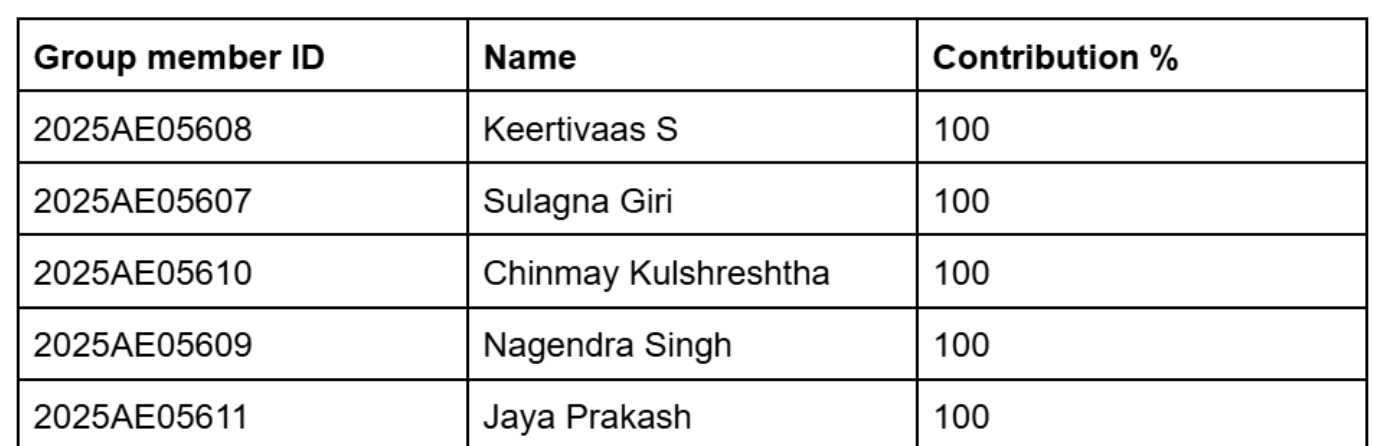

# Names of the classifiers used

#SVM
#Logistic Regression
#Decision Tree
#KNN
#Naive Bayes (Gaussian)

#Import Libraries

In [ ]:
!pip install seaborn
!pip install pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import loguniform
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


#Import Dataset and print the first 2 rows for sanity check


In [ ]:
df = pd.read_excel('/content/agro_dataset.xlsx')

print(df.head(2))


    Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  


#Data Visualization and Exploration

/tmp/ipython-input-541899765.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Class", data=df, palette="viridis")
/tmp/ipython-input-541899765.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, x="Class", palette="viridis")
/tmp/ipython-input-541899765.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y=col, x="Class", palette="viridis")
/tmp/ipython-input-541899765.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable


Missing fraction by column:
Area               0.0
MajorAxisLength    0.0
MinorAxisLength    0.0
Eccentricity       0.0
ConvexArea         0.0
Extent             0.0
Perimeter          0.0
Class              0.0
dtype: float64

Generating Pairplot...


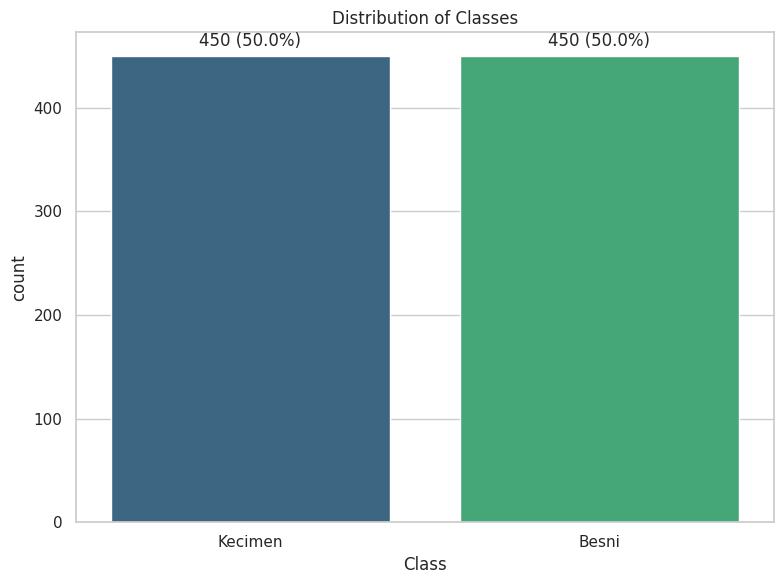

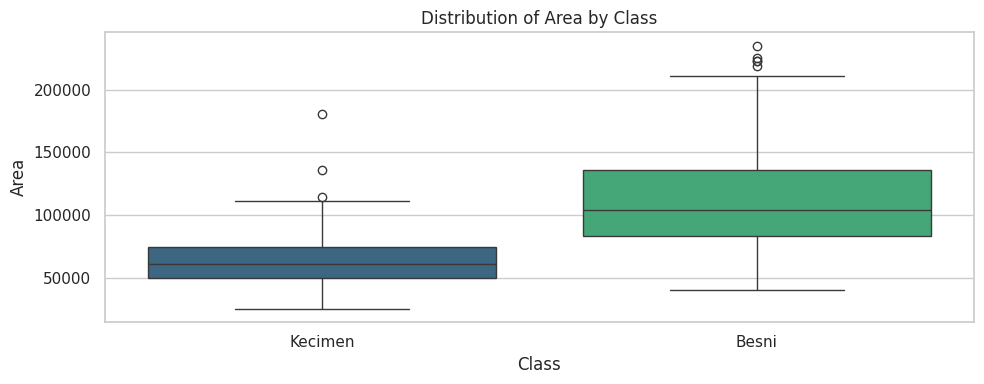

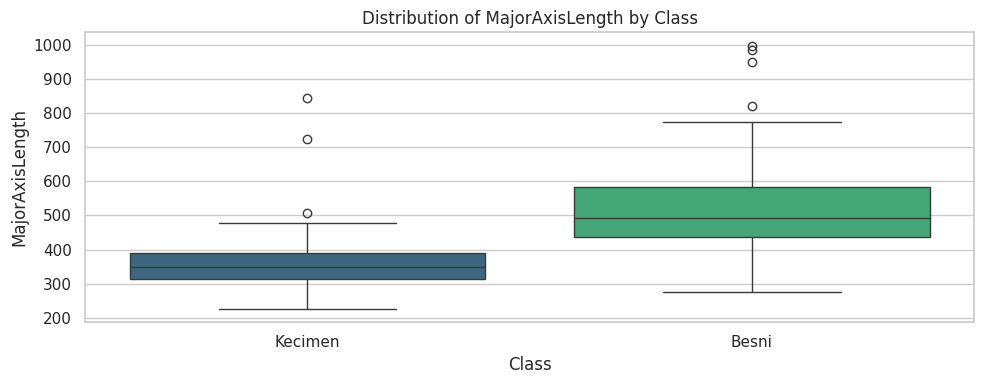

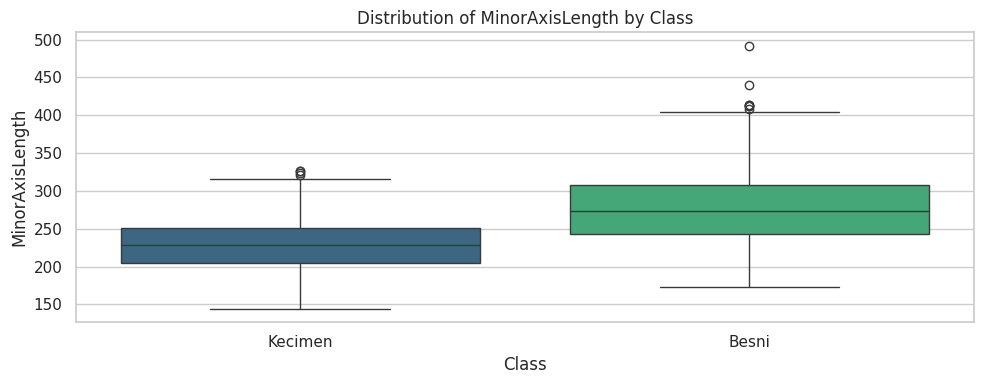

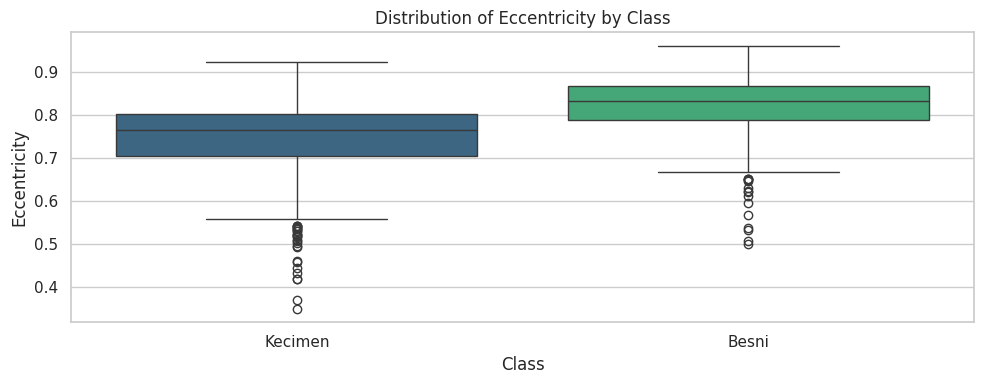

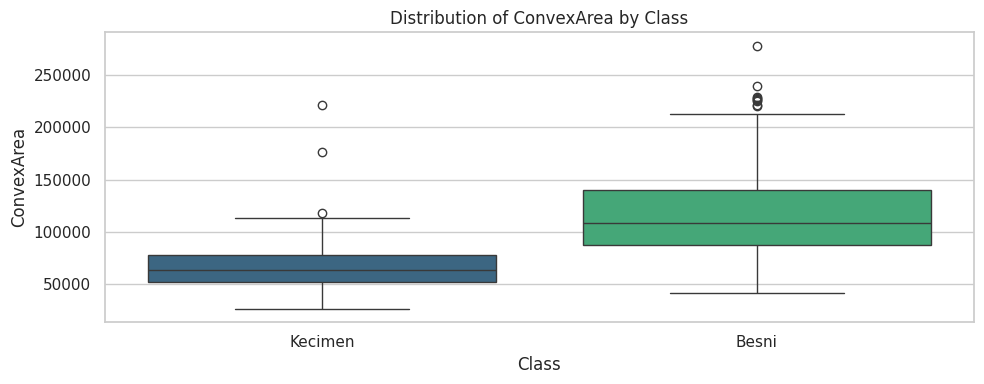

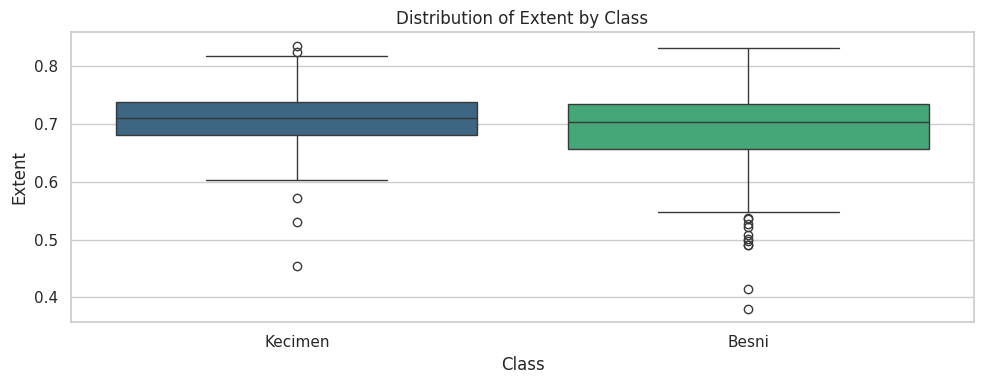

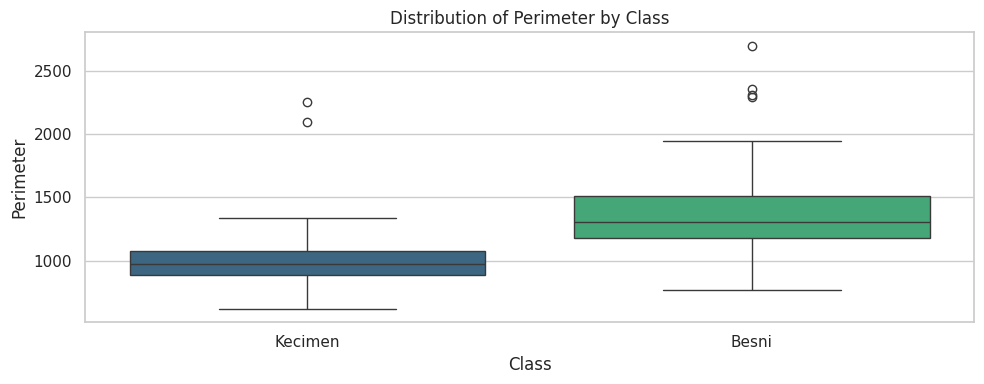

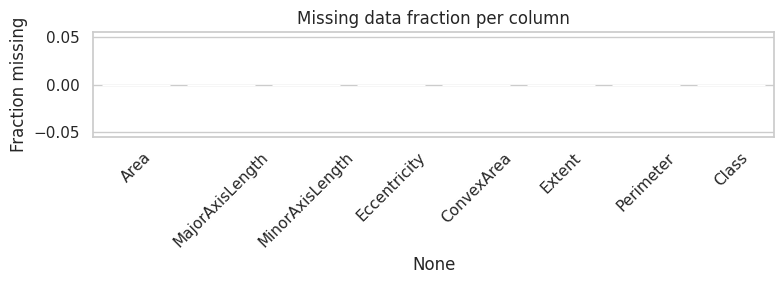

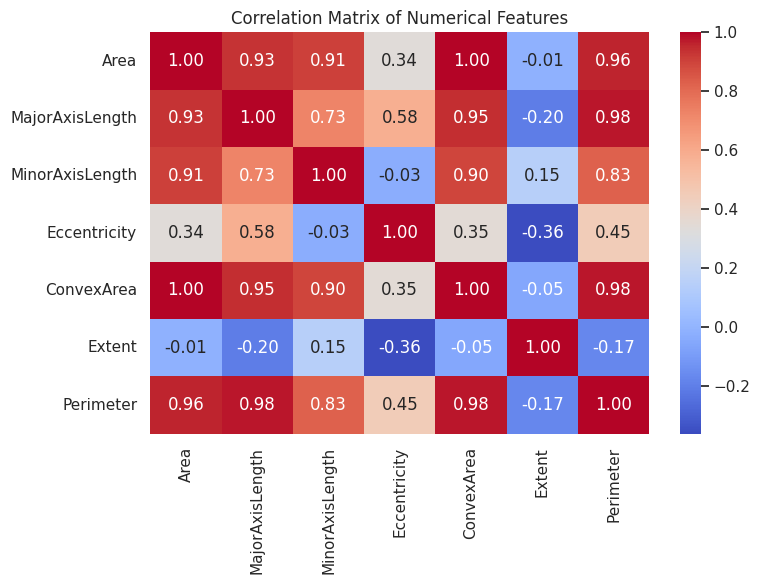

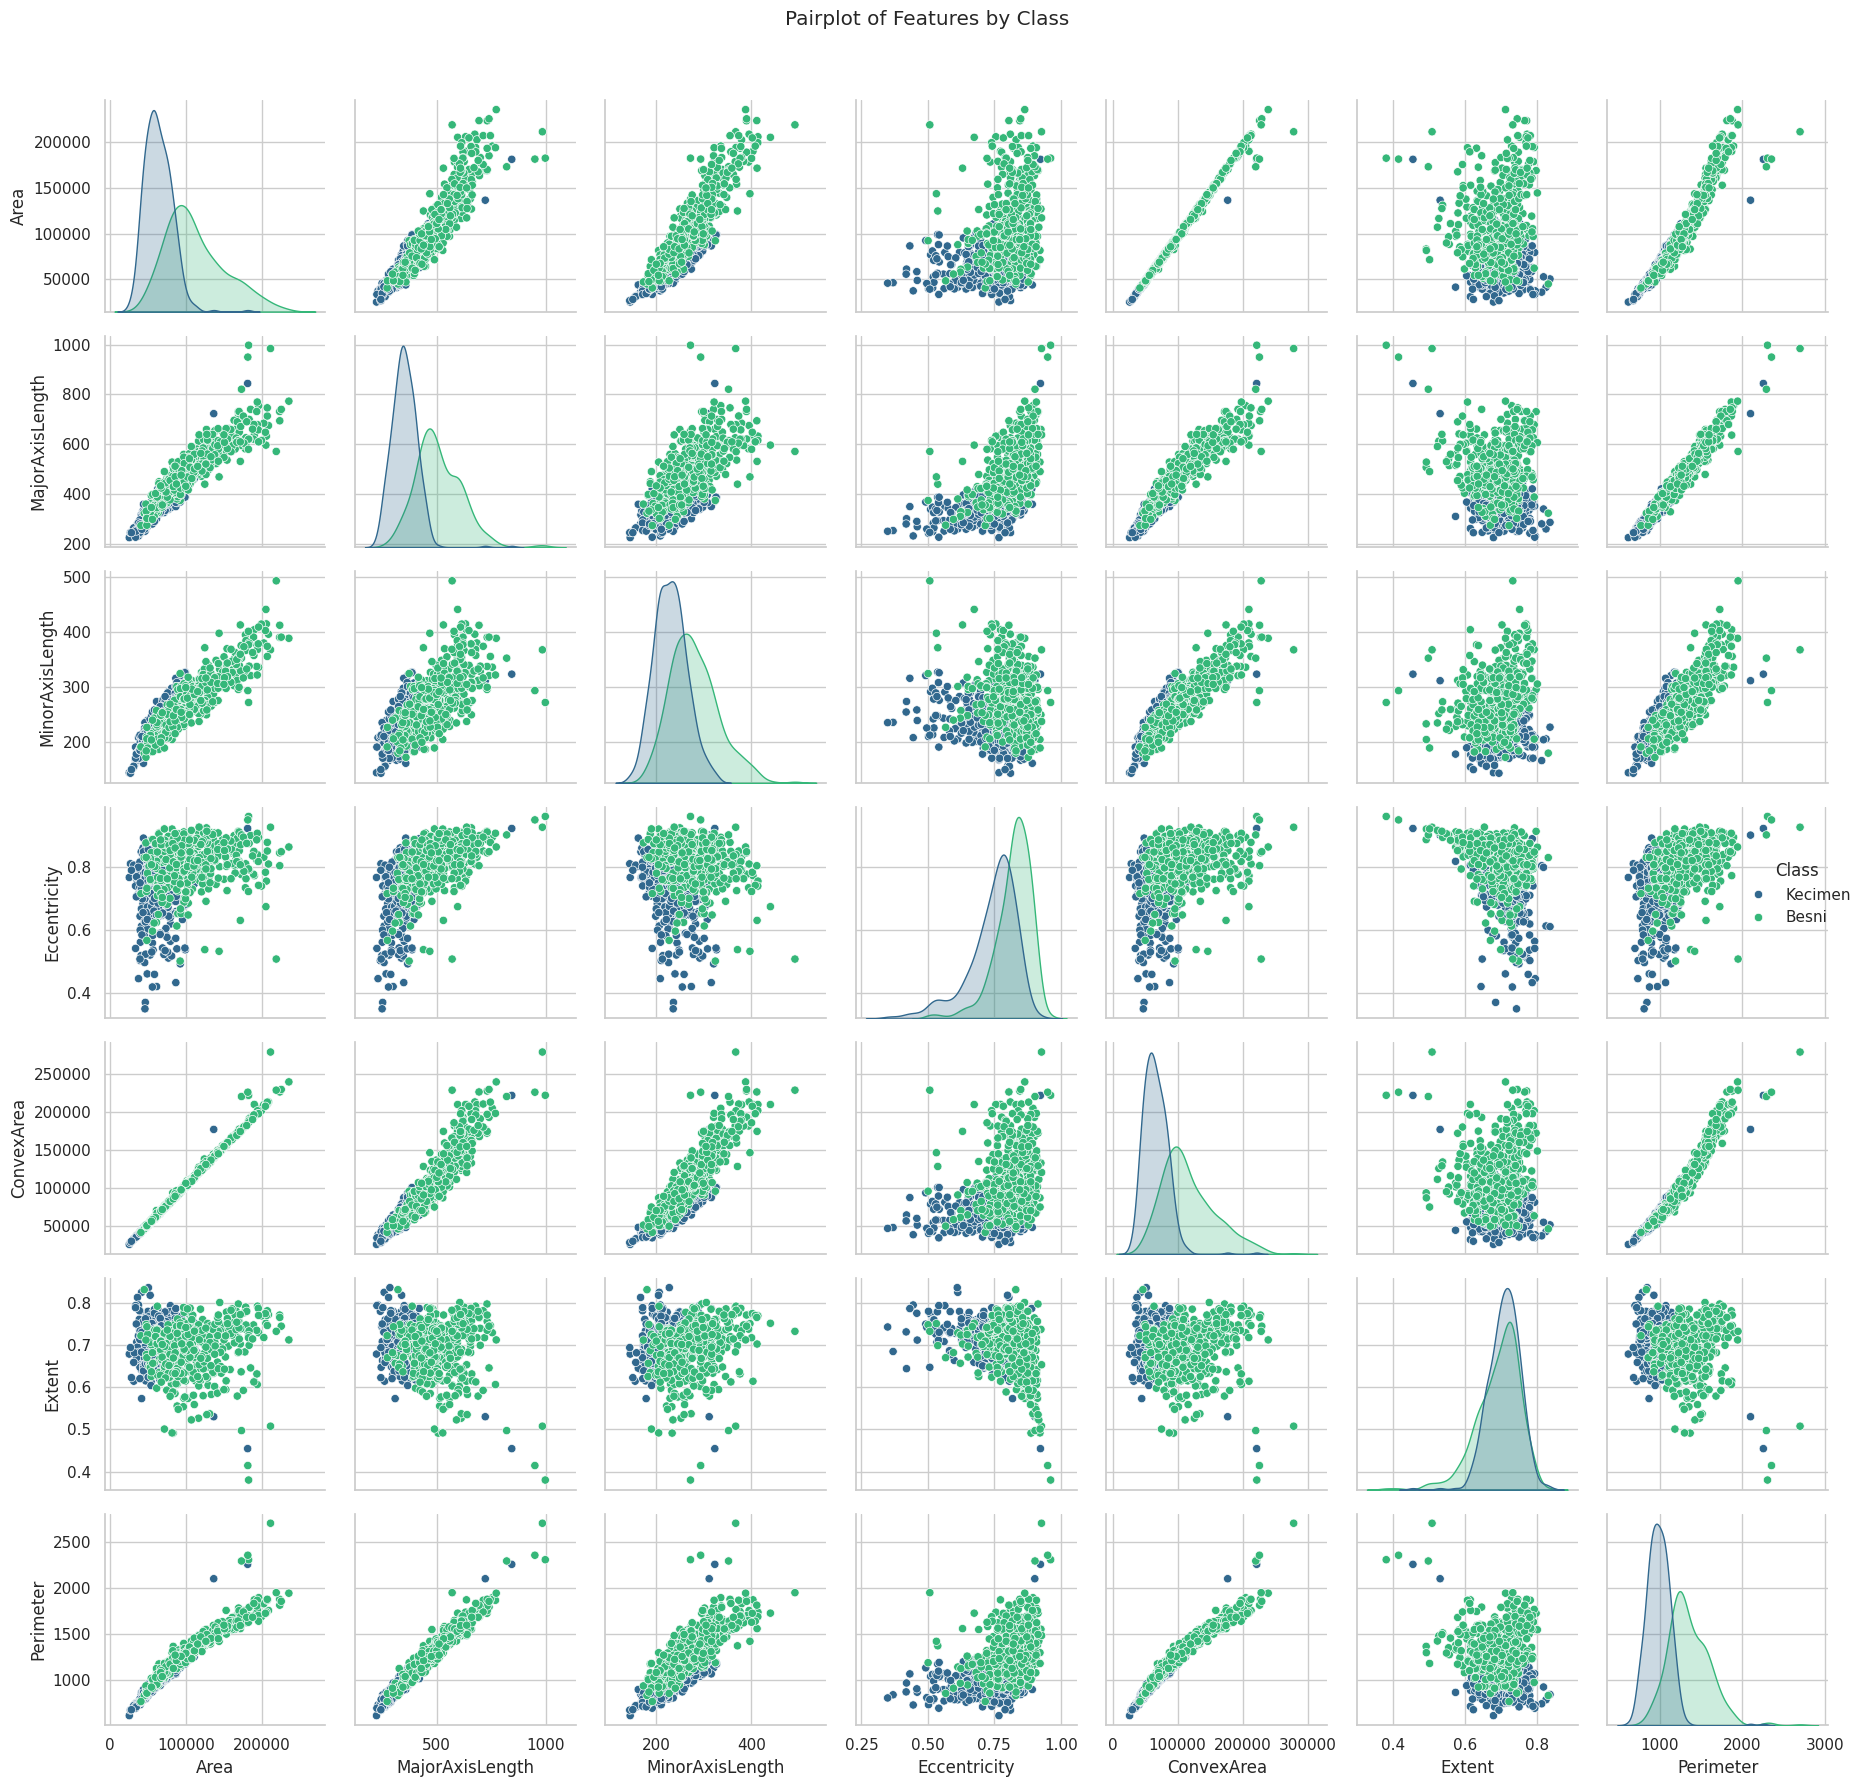

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Class", data=df, palette="viridis")
total = len(df)
for p in ax.patches:
    h = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., h + 0.01 * total, f'{h} ({h/total:.1%})', ha='center')
plt.title("Distribution of Classes")
plt.tight_layout()

numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, y=col, x="Class", palette="viridis")
    plt.title(f'Distribution of {col} by Class')
    plt.tight_layout()

miss_frac = df.isnull().mean().sort_values(ascending=False)
print("\nMissing fraction by column:")
print(miss_frac)
plt.figure(figsize=(8, 3))
sns.barplot(x=miss_frac.index, y=miss_frac.values, palette="magma")
plt.ylabel("Fraction missing")
plt.xticks(rotation=45)
plt.title("Missing data fraction per column")
plt.tight_layout()

plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()

# Pairplot to visualize feature relationships by class
print("\nGenerating Pairplot...")
sns.pairplot(df, hue="Class", palette="viridis")
plt.suptitle("Pairplot of Features by Class", y=1.02) # Add a title to the pairplot
plt.tight_layout()

plt.show()

# Data Visualization and Exploration

The correlational analysis can have an effect on feature selection. High correlation between features indicates that they are providing similar information, which can lead to multicollinearity and redundancy in the model. Identifying these relationships helps in deciding whether to remove one of the highly correlated features or use dimensionality reduction techniques like PCA.

In [ ]:
correlation_matrix = df.corr(numeric_only=True)

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

to_drop_highly_correlated = [column for column in upper.columns if any(upper[column] > 0.95)]

print("Features to drop due to high correlation:", to_drop_highly_correlated)

df_reduced_correlation = df.drop(columns=to_drop_highly_correlated)

print("DataFrame shape after dropping highly correlated features:", df_reduced_correlation.shape)

X = df_reduced_correlation.drop('Class', axis=1)
y = df_reduced_correlation['Class']

numeric_transformer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features_reduced = X.select_dtypes(include=[np.number]).columns
categorical_features_reduced = X.select_dtypes(exclude=[np.number]).columns

preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pipeline, numeric_features_reduced),
        ('cat', categorical_transformer_pipeline, categorical_features_reduced)
    ],
    remainder='passthrough'
)

X_processed = preprocessor_reduced.fit_transform(X)

print("Preprocessing complete with reduced feature set. Processed features shape:", X_processed.shape)


Features to drop due to high correlation: ['ConvexArea', 'Perimeter']
DataFrame shape after dropping highly correlated features: (900, 6)
Preprocessing complete with reduced feature set. Processed features shape: (900, 5)


#Data Pre-processing and cleaning

# Justification of Feature Selection and Transformation Techniques

To prepare the data for modeling, we applied the following techniques:

*   **Correlation-based Feature Selection:** Removed highly correlated features (correlation > 0.95) to mitigate multicollinearity and reduce redundancy, improving model stability and interpretability.

*   **Principal Component Analysis (PCA):** Used in the SVM pipeline for dimensionality reduction by transforming features into a smaller set of uncorrelated components. Useful for handling correlated features and potentially improving performance and efficiency.

*   **Random Forest Feature Importances & SelectKBest:** Employed these methods to identify and select features most relevant to the target variable based on impurity reduction (Random Forest) and statistical association (SelectKBest).

*   **Standardization (using StandardScaler):** Scaled numerical features to zero mean and unit variance. This is crucial for distance-based and gradient-based algorithms (like SVM, Logistic Regression, KNN) to ensure features contribute equally and prevent dominance by features with larger scales.

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

numeric_transformer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pipeline, numeric_features),
        ('cat', categorical_transformer_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

print("Preprocessing complete. Processed features shape:", X_processed.shape)

print("\nTarget variable (first 5 values):")
print(y.head())


Preprocessing complete. Processed features shape: (900, 7)

Target variable (first 5 values):
0    Kecimen
1    Kecimen
2    Kecimen
3    Kecimen
4    Kecimen
Name: Class, dtype: object


In [ ]:
X_processed_df = pd.DataFrame(X_processed, columns=[f'processed_feature_{i}' for i in range(X_processed.shape[1])])

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_processed_df, y)
importances_rf = rf.feature_importances_
feat_importance_rf = pd.Series(importances_rf, index=X_processed_df.columns).sort_values(ascending=False)
print("Random Forest Feature Importances (on processed data):")
print(feat_importance_rf.head(10))

k_best = SelectKBest(score_func=f_classif, k='all')
k_best.fit(X_processed_df, y)
kbest_feat_scores = pd.Series(k_best.scores_, index=X_processed_df.columns).sort_values(ascending=False)
print("SelectKBest Feature Scores (on processed data):")
print(kbest_feat_scores.head(10))

k_best_processed = 6
selected_features_kbest = kbest_feat_scores.head(k_best_processed).index.tolist()
print(f"\nTop {k_best_processed} features selected by SelectKBest: {selected_features_kbest}")


Random Forest Feature Importances (on processed data):
processed_feature_6    0.252325
processed_feature_1    0.244634
processed_feature_4    0.158066
processed_feature_0    0.124583
processed_feature_3    0.085957
processed_feature_2    0.070127
processed_feature_5    0.064307
dtype: float64
SelectKBest Feature Scores (on processed data):
processed_feature_1    744.251543
processed_feature_6    715.744169
processed_feature_0    577.808076
processed_feature_4    577.356620
processed_feature_2    304.321568
processed_feature_3    213.774500
processed_feature_5     22.014600
dtype: float64

Top 6 features selected by SelectKBest: ['processed_feature_1', 'processed_feature_6', 'processed_feature_0', 'processed_feature_4', 'processed_feature_2', 'processed_feature_3']


#Train Test Split

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_split = X_processed
y_split = y_encoded

X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_split, y_split, test_size=0.2, random_state=42, stratify=y_split)
print(f"80/20 split: Train shape: {X_train_80.shape}, Test shape: {X_test_20.shape}")

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_split, y_split, test_size=0.3, random_state=42, stratify=y_split)
print(f"70/30 split: Train shape: {X_train_70.shape}, Test shape: {X_test_30.shape}")

X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X_split, y_split, test_size=0.4, random_state=42, stratify=y_split)
print(f"60/40 split: Train shape: {X_train_60.shape}, Test shape: {X_test_40.shape}")


80/20 split: Train shape: (720, 7), Test shape: (180, 7)
70/30 split: Train shape: (630, 7), Test shape: (270, 7)
60/40 split: Train shape: (540, 7), Test shape: (360, 7)


We split the data into training and testing sets (80/20, 70/30, and 60/40) to evaluate model generalization.

*   **Larger Training Set (e.g., 80/20):** Better for training complex models, but evaluation on the smaller test set might be less precise.
*   **Smaller Training Set (e.g., 60/40):** Provides a more reliable performance estimate on the larger test set, but the model might underfit due to less training data.

Evaluating across these splits helps understand the impact of training data volume on model performance and the confidence in the evaluation metric. Stratified splitting ensures class distribution is maintained in each split.

#Model Building

# Keertivaas S - SVM

Training SVM model with PCA on processed data (80/20 split)...
SVM Accuracy (80/20 split) with PCA: 0.8833333333333333

Classification Report (with PCA):
               precision    recall  f1-score   support

           0       0.95      0.81      0.87        90
           1       0.83      0.96      0.89        90

    accuracy                           0.88       180
   macro avg       0.89      0.88      0.88       180
weighted avg       0.89      0.88      0.88       180


Confusion Matrix (with PCA):
 [[73 17]
 [ 4 86]]


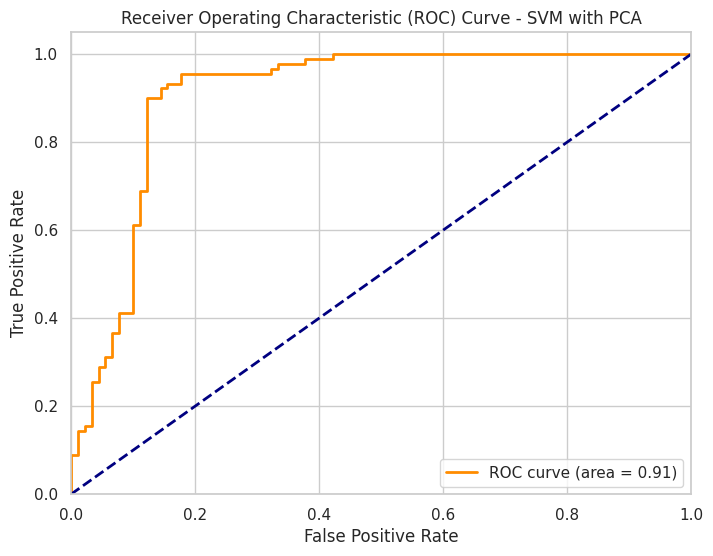

In [ ]:
print("Training SVM model with PCA on processed data (80/20 split)...")

svm_pipeline_pca = Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                                  ('classifier', SVC(random_state=42, probability=True))])

svm_pipeline_pca.fit(X_train_80, y_train_80)

y_pred_svm_pca = svm_pipeline_pca.predict(X_test_20)

print("SVM Accuracy (80/20 split) with PCA:", accuracy_score(y_test_20, y_pred_svm_pca))

n_classes = len(np.unique(y_train_80))

if n_classes > 2:
    print("\nClassification Report (with PCA):\n", classification_report(y_test_20, y_pred_svm_pca))
    print("\nConfusion Matrix (with PCA):\n", confusion_matrix(y_test_20, y_pred_svm_pca))
else:
    print("\nClassification Report (with PCA):\n", classification_report(y_test_20, y_pred_svm_pca, zero_division=0))
    print("\nConfusion Matrix (with PCA):\n", confusion_matrix(y_test_20, y_pred_svm_pca))

if n_classes == 2:
    y_prob_svm_pca = svm_pipeline_pca.predict_proba(X_test_20)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_20, y_prob_svm_pca)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - SVM with PCA')
    plt.legend(loc="lower right")
    plt.show()


**SVM Hyperparameter Justification:**

*   `C` (Regularization parameter): Controls the trade-off between classification error and margin size.
*   `gamma` (Kernel coefficient): Influences the shape of the decision boundary, especially with non-linear kernels.
*   `kernel` (Kernel type): Determines the type of hyperplane used for separation ('rbf', 'linear').

Performing GridSearchCV with PCA (80/20 split)...

Best parameters found by GridSearchCV (80/20 split with PCA):
{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best accuracy found by GridSearchCV (80/20 split with PCA): 0.8666666666666667

GridSearchCV Test Accuracy (80/20 split) with PCA: 0.8722222222222222

Performing GridSearchCV with PCA (70/30 split)...

Best parameters found by GridSearchCV (70/30 split with PCA):
{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best accuracy found by GridSearchCV (70/30 split with PCA): 0.8793650793650793

GridSearchCV Test Accuracy (70/30 split) with PCA: 0.837037037037037

Performing GridSearchCV with PCA (60/40 split)...

Best parameters found by GridSearchCV (60/40 split with PCA):
{'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best accuracy found by GridSearchCV (60/40 split with PCA): 0.8722222222222222

GridSearchCV Test Accuracy (60/40 

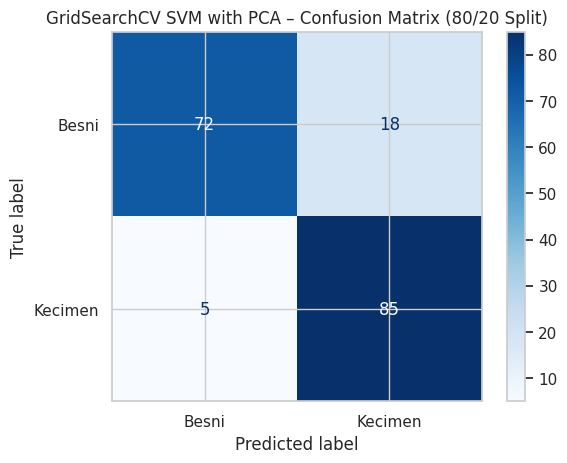


GridSearchCV Classification Report (70/30 split with PCA):
               precision    recall  f1-score   support

       Besni       0.89      0.77      0.83       135
     Kecimen       0.80      0.90      0.85       135

    accuracy                           0.84       270
   macro avg       0.84      0.84      0.84       270
weighted avg       0.84      0.84      0.84       270


GridSearchCV Confusion Matrix (70/30 split with PCA):


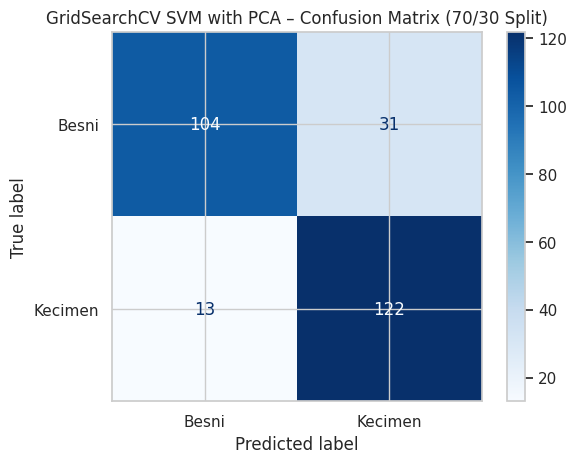


GridSearchCV Classification Report (60/40 split with PCA):
               precision    recall  f1-score   support

       Besni       0.90      0.79      0.84       180
     Kecimen       0.82      0.91      0.86       180

    accuracy                           0.85       360
   macro avg       0.86      0.85      0.85       360
weighted avg       0.86      0.85      0.85       360


GridSearchCV Confusion Matrix (60/40 split with PCA):


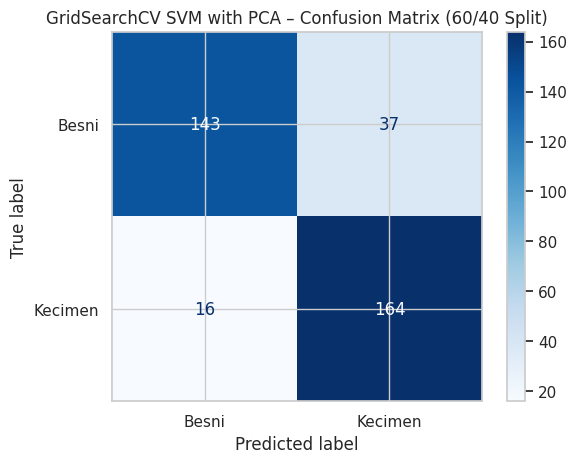


Performing RandomizedSearchCV with PCA (80/20 split)...

Best parameters found by RandomizedSearchCV (80/20 split with PCA):
{'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__C': np.float64(0.2442053094548651)}
Best accuracy found by RandomizedSearchCV (80/20 split with PCA): 0.8666666666666667

RandomizedSearchCV Test Accuracy (80/20 split) with PCA: 0.8777777777777778

Performing RandomizedSearchCV with PCA (70/30 split)...

Best parameters found by RandomizedSearchCV (70/30 split with PCA):
{'classifier__kernel': 'linear', 'classifier__gamma': 'auto', 'classifier__C': np.float64(0.017575106248547922)}
Best accuracy found by RandomizedSearchCV (70/30 split with PCA): 0.8809523809523809

RandomizedSearchCV Test Accuracy (70/30 split) with PCA: 0.8444444444444444

Performing RandomizedSearchCV with PCA (60/40 split)...

Best parameters found by RandomizedSearchCV (60/40 split with PCA):
{'classifier__kernel': 'linear', 'classifier__gamma': 'auto', 'classifier

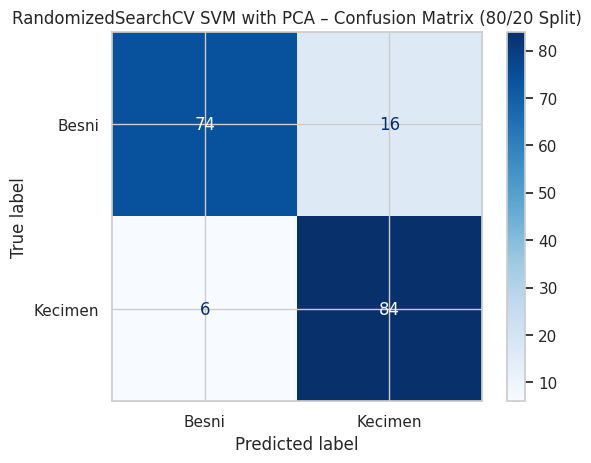


RandomizedSearchCV Classification Report (70/30 split with PCA):
               precision    recall  f1-score   support

       Besni       0.88      0.79      0.84       135
     Kecimen       0.81      0.90      0.85       135

    accuracy                           0.84       270
   macro avg       0.85      0.84      0.84       270
weighted avg       0.85      0.84      0.84       270


RandomizedSearchCV Confusion Matrix (70/30 split with PCA):


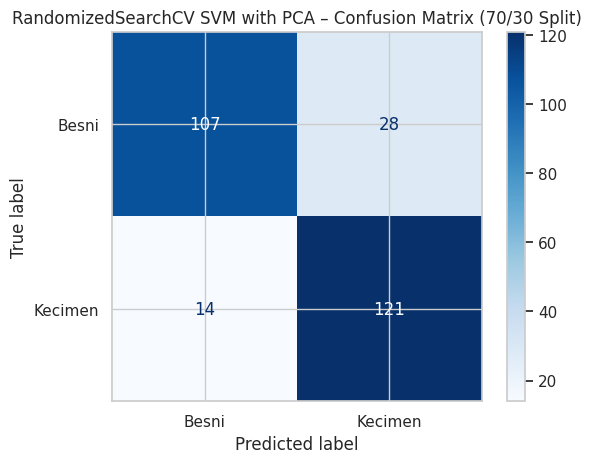


RandomizedSearchCV Classification Report (60/40 split with PCA):
               precision    recall  f1-score   support

       Besni       0.90      0.81      0.85       180
     Kecimen       0.83      0.91      0.86       180

    accuracy                           0.86       360
   macro avg       0.86      0.86      0.86       360
weighted avg       0.86      0.86      0.86       360


RandomizedSearchCV Confusion Matrix (60/40 split with PCA):


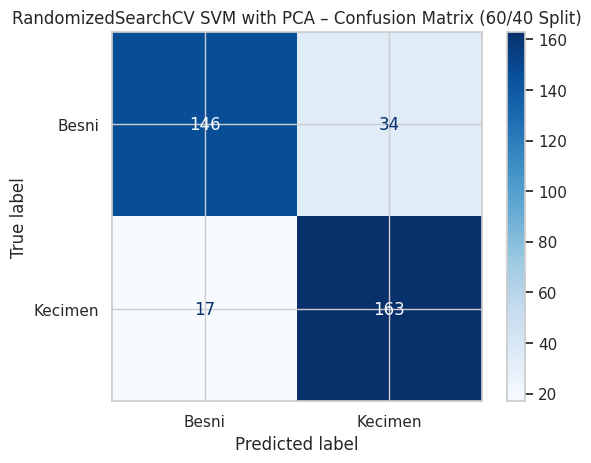


--- GridSearchCV ROC Curves ---


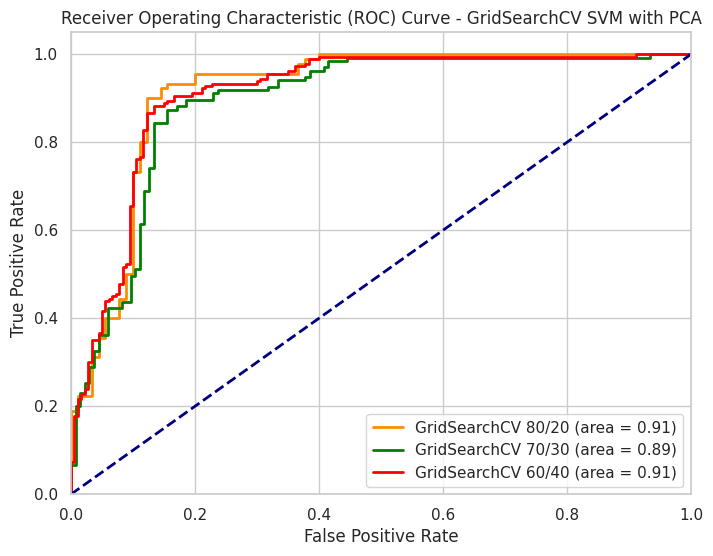


--- RandomizedSearchCV ROC Curves ---


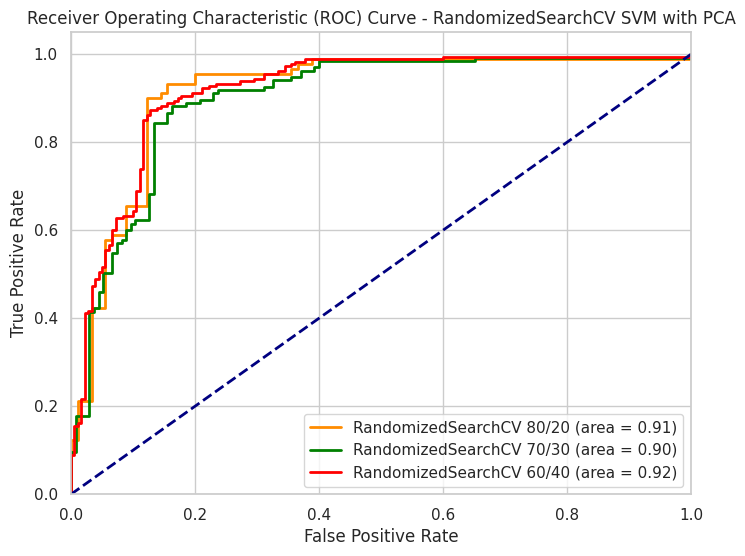

In [ ]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf', 'linear']
}

svm_pipeline_tuned = Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=42)),
                                     ('classifier', SVC(random_state=42, probability=True))])

print("Performing GridSearchCV with PCA (80/20 split)...")
grid_search_80 = GridSearchCV(svm_pipeline_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_80.fit(X_train_80, y_train_80)
print("\nBest parameters found by GridSearchCV (80/20 split with PCA):")
print(grid_search_80.best_params_)
print("Best accuracy found by GridSearchCV (80/20 split with PCA):", grid_search_80.best_score_)
y_pred_grid_80 = grid_search_80.predict(X_test_20)
print("\nGridSearchCV Test Accuracy (80/20 split) with PCA:", accuracy_score(y_test_20, y_pred_grid_80))

print("\nPerforming GridSearchCV with PCA (70/30 split)...")
grid_search_70 = GridSearchCV(svm_pipeline_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_70.fit(X_train_70, y_train_70)
print("\nBest parameters found by GridSearchCV (70/30 split with PCA):")
print(grid_search_70.best_params_)
print("Best accuracy found by GridSearchCV (70/30 split with PCA):", grid_search_70.best_score_)
y_pred_grid_70 = grid_search_70.predict(X_test_30)
print("\nGridSearchCV Test Accuracy (70/30 split) with PCA:", accuracy_score(y_test_30, y_pred_grid_70))

print("\nPerforming GridSearchCV with PCA (60/40 split)...")
grid_search_60 = GridSearchCV(svm_pipeline_tuned, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_60.fit(X_train_60, y_train_60)
print("\nBest parameters found by GridSearchCV (60/40 split with PCA):")
print(grid_search_60.best_params_)
print("Best accuracy found by GridSearchCV (60/40 split with PCA):", grid_search_60.best_score_)
y_pred_grid_60 = grid_search_60.predict(X_test_40)
print("\nGridSearchCV Test Accuracy (60/40 split) with PCA:", accuracy_score(y_test_40, y_pred_grid_60))


n_classes = len(np.unique(y_train_80))
class_names = label_encoder.classes_

print("\n--- GridSearchCV Classification Reports and Confusion Matrices ---")

print("\nGridSearchCV Classification Report (80/20 split with PCA):\n", classification_report(y_test_20, y_pred_grid_80, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (80/20 split with PCA):")
cm_grid_80 = confusion_matrix(y_test_20, y_pred_grid_80)
ConfusionMatrixDisplay(cm_grid_80, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV SVM with PCA – Confusion Matrix (80/20 Split)')
plt.show()

print("\nGridSearchCV Classification Report (70/30 split with PCA):\n", classification_report(y_test_30, y_pred_grid_70, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (70/30 split with PCA):")
cm_grid_70 = confusion_matrix(y_test_30, y_pred_grid_70)
ConfusionMatrixDisplay(cm_grid_70, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV SVM with PCA – Confusion Matrix (70/30 Split)')
plt.show()

print("\nGridSearchCV Classification Report (60/40 split with PCA):\n", classification_report(y_test_40, y_pred_grid_60, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (60/40 split with PCA):")
cm_grid_60 = confusion_matrix(y_test_40, y_pred_grid_60)
ConfusionMatrixDisplay(cm_grid_60, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV SVM with PCA – Confusion Matrix (60/40 Split)')
plt.show()


param_dist = {
    'classifier__C': np.logspace(-2, 2, 50),
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf', 'linear']
}

print("\nPerforming RandomizedSearchCV with PCA (80/20 split)...")
random_search_80 = RandomizedSearchCV(svm_pipeline_tuned, param_dist, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_80.fit(X_train_80, y_train_80)
print("\nBest parameters found by RandomizedSearchCV (80/20 split with PCA):")
print(random_search_80.best_params_)
print("Best accuracy found by RandomizedSearchCV (80/20 split with PCA):", random_search_80.best_score_)
y_pred_random_80 = random_search_80.predict(X_test_20)
print("\nRandomizedSearchCV Test Accuracy (80/20 split) with PCA:", accuracy_score(y_test_20, y_pred_random_80))

print("\nPerforming RandomizedSearchCV with PCA (70/30 split)...")
random_search_70 = RandomizedSearchCV(svm_pipeline_tuned, param_dist, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_70.fit(X_train_70, y_train_70)
print("\nBest parameters found by RandomizedSearchCV (70/30 split with PCA):")
print(random_search_70.best_params_)
print("Best accuracy found by RandomizedSearchCV (70/30 split with PCA):", random_search_70.best_score_)
y_pred_random_70 = random_search_70.predict(X_test_30)
print("\nRandomizedSearchCV Test Accuracy (70/30 split) with PCA:", accuracy_score(y_test_30, y_pred_random_70))

print("\nPerforming RandomizedSearchCV with PCA (60/40 split)...")
random_search_60 = RandomizedSearchCV(svm_pipeline_tuned, param_dist, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_60.fit(X_train_60, y_train_60)
print("\nBest parameters found by RandomizedSearchCV (60/40 split with PCA):")
print(random_search_60.best_params_)
print("Best accuracy found by RandomizedSearchCV (60/40 split with PCA):", random_search_60.best_score_)
y_pred_random_60 = random_search_60.predict(X_test_40)
print("\nRandomizedSearchCV Test Accuracy (60/40 split) with PCA:", accuracy_score(y_test_40, y_pred_random_60))

print("\n--- RandomizedSearchCV Classification Reports and Confusion Matrices ---")

print("\nRandomizedSearchCV Classification Report (80/20 split with PCA):\n", classification_report(y_test_20, y_pred_random_80, target_names=class_names))
print("\nRandomizedSearchCV Confusion Matrix (80/20 split with PCA):")
cm_random_80 = confusion_matrix(y_test_20, y_pred_random_80)
ConfusionMatrixDisplay(cm_random_80, display_labels=class_names).plot(cmap='Blues')
plt.title('RandomizedSearchCV SVM with PCA – Confusion Matrix (80/20 Split)')
plt.show()

print("\nRandomizedSearchCV Classification Report (70/30 split with PCA):\n", classification_report(y_test_30, y_pred_random_70, target_names=class_names))
print("\nRandomizedSearchCV Confusion Matrix (70/30 split with PCA):")
cm_random_70 = confusion_matrix(y_test_30, y_pred_random_70)
ConfusionMatrixDisplay(cm_random_70, display_labels=class_names).plot(cmap='Blues')
plt.title('RandomizedSearchCV SVM with PCA – Confusion Matrix (70/30 Split)')
plt.show()

print("\nRandomizedSearchCV Classification Report (60/40 split with PCA):\n", classification_report(y_test_40, y_pred_random_60, target_names=class_names))
print("\nRandomizedSearchCV Confusion Matrix (60/40 split with PCA):")
cm_random_60 = confusion_matrix(y_test_40, y_pred_random_60)
ConfusionMatrixDisplay(cm_random_60, display_labels=class_names).plot(cmap='Blues')
plt.title('RandomizedSearchCV SVM with PCA – Confusion Matrix (60/40 Split)')
plt.show()


if n_classes == 2:
    print("\n--- GridSearchCV ROC Curves ---")
    plt.figure(figsize=(8, 6))

    # 80/20 split ROC
    y_prob_grid_80 = grid_search_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_grid_80, tpr_grid_80, _ = roc_curve(y_test_20, y_prob_grid_80)
    roc_auc_grid_80 = auc(fpr_grid_80, tpr_grid_80)
    plt.plot(fpr_grid_80, tpr_grid_80, color='darkorange', lw=2, label='GridSearchCV 80/20 (area = %0.2f)' % roc_auc_grid_80)

    # 70/30 split ROC
    y_prob_grid_70 = grid_search_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_grid_70, tpr_grid_70, _ = roc_curve(y_test_30, y_prob_grid_70)
    roc_auc_grid_70 = auc(fpr_grid_70, tpr_grid_70)
    plt.plot(fpr_grid_70, tpr_grid_70, color='green', lw=2, label='GridSearchCV 70/30 (area = %0.2f)' % roc_auc_grid_70)

    # 60/40 split ROC
    y_prob_grid_60 = grid_search_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_grid_60, tpr_grid_60, _ = roc_curve(y_test_40, y_prob_grid_60)
    roc_auc_grid_60 = auc(fpr_grid_60, tpr_grid_60)
    plt.plot(fpr_grid_60, tpr_grid_60, color='red', lw=2, label='GridSearchCV 60/40 (area = %0.2f)' % roc_auc_grid_60)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - GridSearchCV SVM with PCA')
    plt.legend(loc="lower right")
    plt.show()


    print("\n--- RandomizedSearchCV ROC Curves ---")
    plt.figure(figsize=(8, 6))

    # 80/20 split ROC
    y_prob_random_80 = random_search_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_random_80, tpr_random_80, _ = roc_curve(y_test_20, y_prob_random_80)
    roc_auc_random_80 = auc(fpr_random_80, tpr_random_80)
    plt.plot(fpr_random_80, tpr_random_80, color='darkorange', lw=2, label='RandomizedSearchCV 80/20 (area = %0.2f)' % roc_auc_random_80)

    # 70/30 split ROC
    y_prob_random_70 = random_search_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_random_70, tpr_random_70, _ = roc_curve(y_test_30, y_prob_random_70)
    roc_auc_random_70 = auc(fpr_random_70, tpr_random_70)
    plt.plot(fpr_random_70, tpr_random_70, color='green', lw=2, label='RandomizedSearchCV 70/30 (area = %0.2f)' % roc_auc_random_70)

    # 60/40 split ROC
    y_prob_random_60 = random_search_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_random_60, tpr_random_60, _ = roc_curve(y_test_40, y_prob_random_60)
    roc_auc_random_60 = auc(fpr_random_60, tpr_random_60)
    plt.plot(fpr_random_60, tpr_random_60, color='red', lw=2, label='RandomizedSearchCV 60/40 (area = %0.2f)' % roc_auc_random_60)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - RandomizedSearchCV SVM with PCA')
    plt.legend(loc="lower right")
    plt.show()


# Sulagna - Logistic Regression

Training Logistic Regression model...

Logistic Regression Accuracy (80/20 split): 0.8888888888888888

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.94      0.83      0.88        90
           1       0.85      0.94      0.89        90

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180


Confusion Matrix (Logistic Regression):
 [[75 15]
 [ 5 85]]


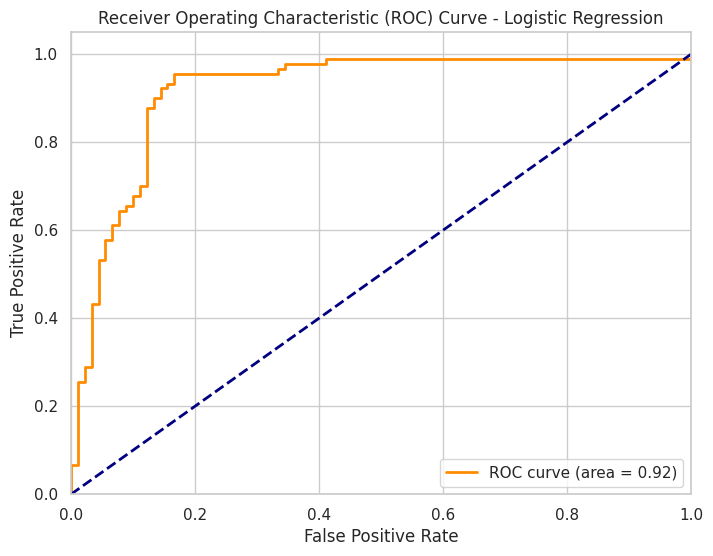

In [ ]:
print("Training Logistic Regression model...")

lr_pipeline = Pipeline(steps=[('classifier', LogisticRegression(random_state=42, max_iter=1000))])

lr_pipeline.fit(X_train_80, y_train_80)

y_pred_lr = lr_pipeline.predict(X_test_20)

print("\nLogistic Regression Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_lr))

n_classes = len(np.unique(y_train_80))

if n_classes > 2:
    print("\nClassification Report (Logistic Regression):\n", classification_report(y_test_20, y_pred_lr))
    print("\nConfusion Matrix (Logistic Regression):\n", confusion_matrix(y_test_20, y_pred_lr))
else:
    print("\nClassification Report (Logistic Regression):\n", classification_report(y_test_20, y_pred_lr, zero_division=0))
    print("\nConfusion Matrix (Logistic Regression):\n", confusion_matrix(y_test_20, y_pred_lr))

if n_classes == 2:
    y_prob_lr = lr_pipeline.predict_proba(X_test_20)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_20, y_prob_lr)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

**Logistic Regression Hyperparameter Justification:**

*   `C` (Inverse of regularization strength): Controls the amount of regularization applied.
*   `penalty` (Regularization type): Specifies the norm used for penalization ('l1', 'l2', 'elasticnet', 'none').
*   `solver` (Optimization algorithm): Selects the algorithm for finding the optimal model parameters.
*   `l1_ratio` (Elastic-Net mixing parameter): Balances L1 and L2 penalties when `penalty` is 'elasticnet'.


--- Starting GridSearchCV for LogisticRegression (80/20 split) ---
Fitting 3 folds for each of 35 candidates, totalling 105 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- GridSearchCV (LogisticRegression) Complete (80/20 split) ---
Best parameters found (80/20 split): {'C': 100, 'l1_ratio': 0.5, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation accuracy (80/20 split): 0.8681

GridSearchCV Test Accuracy (80/20 split): 0.8944

--- Starting GridSearchCV for LogisticRegression (70/30 split) ---
Fitting 3 folds for each of 35 candidates, totalling 105 fits

--- GridSearchCV (LogisticRegression) Complete (70/30 split) ---
Best parameters found (70/30 split): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy (70/30 split): 0.8825

GridSearchCV Test Accuracy (70/30 split): 0.8444

--- Starting GridSearchCV for LogisticRegression (60/40 split) ---
Fitting 3 folds for each of 35 candidates, totalling 105 fits

--- GridSearchCV (LogisticRegression) Complete (60/40 split) ---
Best parameters found (60/40 split): {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy (60/40 split): 0.8704

GridS

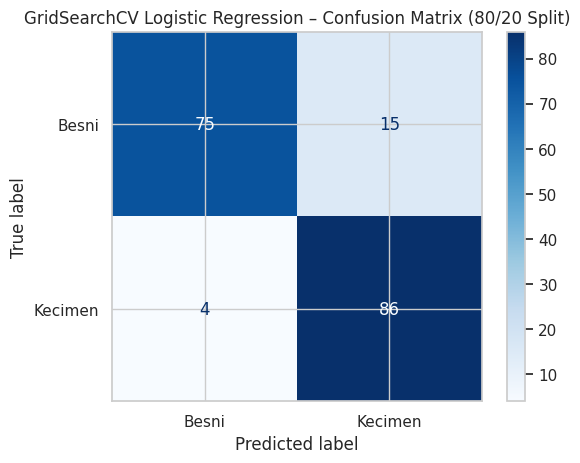


GridSearchCV Classification Report (70/30 split):
               precision    recall  f1-score   support

       Besni       0.88      0.79      0.84       135
     Kecimen       0.81      0.90      0.85       135

    accuracy                           0.84       270
   macro avg       0.85      0.84      0.84       270
weighted avg       0.85      0.84      0.84       270


GridSearchCV Confusion Matrix (70/30 split):
 [[107  28]
 [ 14 121]]


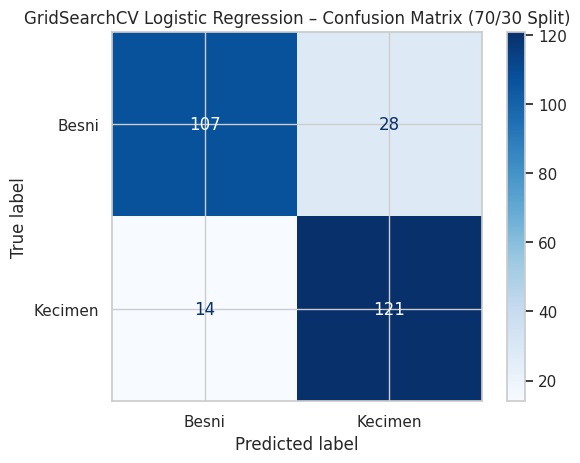


GridSearchCV Classification Report (60/40 split):
               precision    recall  f1-score   support

       Besni       0.92      0.77      0.84       180
     Kecimen       0.80      0.93      0.86       180

    accuracy                           0.85       360
   macro avg       0.86      0.85      0.85       360
weighted avg       0.86      0.85      0.85       360


GridSearchCV Confusion Matrix (60/40 split):
 [[138  42]
 [ 12 168]]


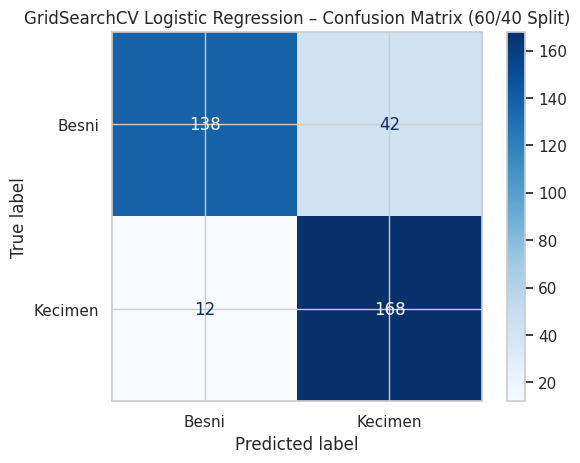


---  Starting RandomizedSearchCV for LogisticRegression (80/20 split) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- RandomizedSearchCV (LogisticRegression) Complete (80/20 split) ---
Best parameters found (80/20 split): {'C': np.float64(15.352246941973492), 'l1_ratio': np.float64(0.7777777777777777), 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation accuracy (80/20 split): 0.8667

RandomizedSearchCV Test Accuracy (80/20 split): 0.8944

---  Starting RandomizedSearchCV for LogisticRegression (70/30 split) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- RandomizedSearchCV (LogisticRegression) Complete (70/30 split) ---
Best parameters found (70/30 split): {'C': np.float64(0.04207988669606638), 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy (70/30 split): 0.8810

RandomizedSearchCV Test Accuracy (70/30 split): 0.8444

---  Starting RandomizedSearchCV for LogisticRegression (60/40 split) ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- RandomizedSearchCV (LogisticRegression) Complete (60/40 split) ---
Best parameters found (60/40

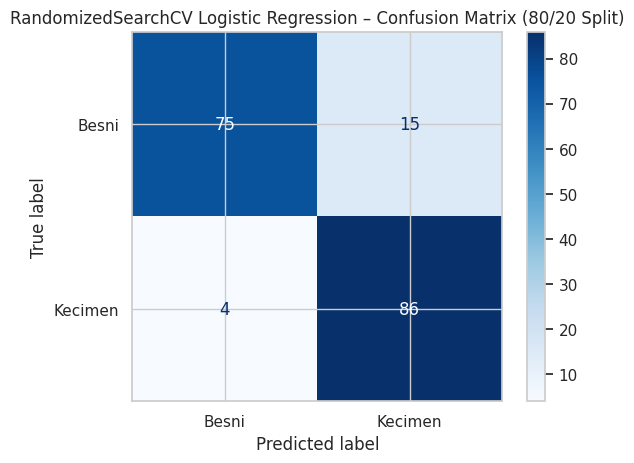


RandomizedSearchCV Classification Report (70/30 split):
               precision    recall  f1-score   support

       Besni       0.88      0.79      0.84       135
     Kecimen       0.81      0.90      0.85       135

    accuracy                           0.84       270
   macro avg       0.85      0.84      0.84       270
weighted avg       0.85      0.84      0.84       270


RandomizedSearchCV Confusion Matrix (70/30 split):
 [[107  28]
 [ 14 121]]


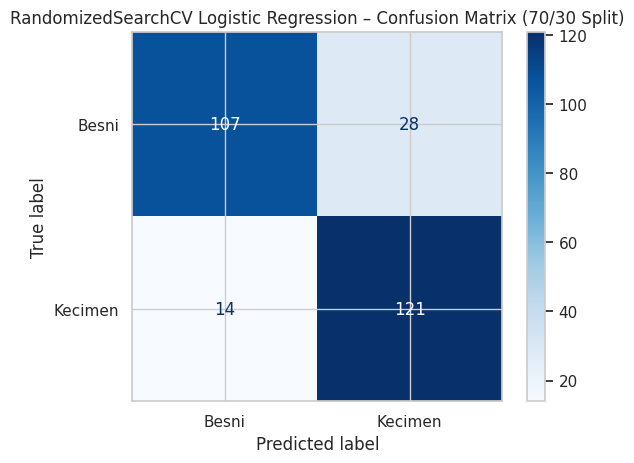


RandomizedSearchCV Classification Report (60/40 split):
               precision    recall  f1-score   support

       Besni       0.92      0.77      0.84       180
     Kecimen       0.80      0.93      0.86       180

    accuracy                           0.85       360
   macro avg       0.86      0.85      0.85       360
weighted avg       0.86      0.85      0.85       360


RandomizedSearchCV Confusion Matrix (60/40 split):
 [[138  42]
 [ 12 168]]


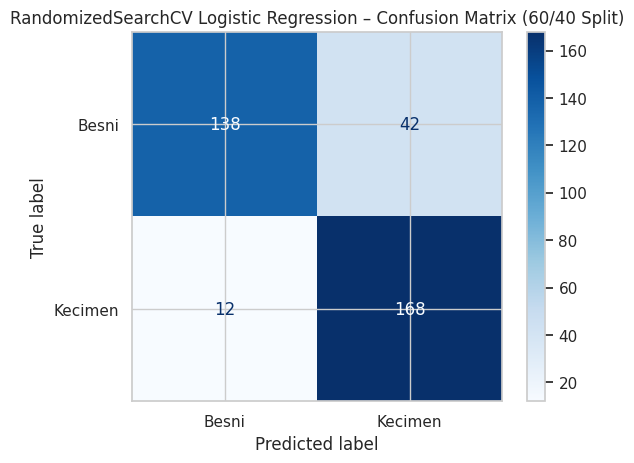


--- GridSearchCV ROC Curves ---


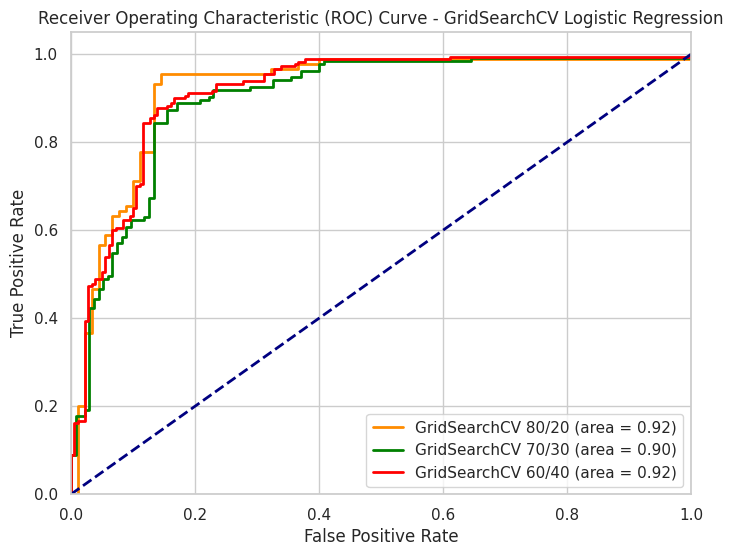


--- RandomizedSearchCV ROC Curves ---


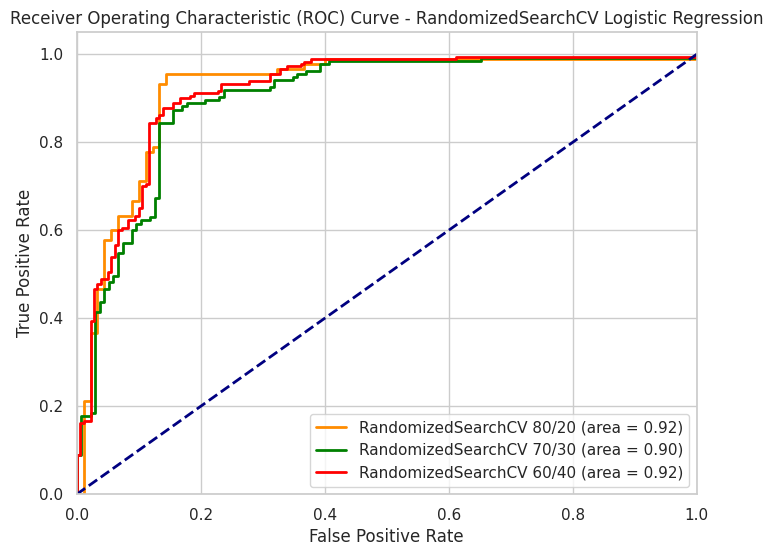

In [ ]:
class_names = label_encoder.classes_

lr = LogisticRegression(random_state=42, max_iter=2000)

print("\n--- Starting GridSearchCV for LogisticRegression (80/20 split) ---")

param_grid = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.5]
    }
]


grid_search_lr_80 = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_lr_80.fit(X_train_80, y_train_80)

print("\n--- GridSearchCV (LogisticRegression) Complete (80/20 split) ---")
print(f"Best parameters found (80/20 split): {grid_search_lr_80.best_params_}")
print(f"Best cross-validation accuracy (80/20 split): {grid_search_lr_80.best_score_:.4f}")


y_pred_grid_lr_80 = grid_search_lr_80.predict(X_test_20)
print(f"\nGridSearchCV Test Accuracy (80/20 split): {accuracy_score(y_test_20, y_pred_grid_lr_80):.4f}")

# Evaluate on 70/30 split
print("\n--- Starting GridSearchCV for LogisticRegression (70/30 split) ---")
grid_search_lr_70 = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
# Assuming X_train_70, y_train_70, X_test_30, y_test_30 are already defined
grid_search_lr_70.fit(X_train_70, y_train_70)
print("\n--- GridSearchCV (LogisticRegression) Complete (70/30 split) ---")
print(f"Best parameters found (70/30 split): {grid_search_lr_70.best_params_}")
print(f"Best cross-validation accuracy (70/30 split): {grid_search_lr_70.best_score_:.4f}")
y_pred_grid_lr_70 = grid_search_lr_70.predict(X_test_30)
print(f"\nGridSearchCV Test Accuracy (70/30 split): {accuracy_score(y_test_30, y_pred_grid_lr_70):.4f}")

# Evaluate on 60/40 split
print("\n--- Starting GridSearchCV for LogisticRegression (60/40 split) ---")
grid_search_lr_60 = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
# Assuming X_train_60, y_train_60, X_test_40, y_test_40 are already defined
grid_search_lr_60.fit(X_train_60, y_train_60)
print("\n--- GridSearchCV (LogisticRegression) Complete (60/40 split) ---")
print(f"Best parameters found (60/40 split): {grid_search_lr_60.best_params_}")
print(f"Best cross-validation accuracy (60/40 split): {grid_search_lr_60.best_score_:.4f}")
y_pred_grid_lr_60 = grid_search_lr_60.predict(X_test_40)
print(f"\nGridSearchCV Test Accuracy (60/40 split): {accuracy_score(y_test_40, y_pred_grid_lr_60):.4f}")


if n_classes > 2:
    print("\nGridSearchCV Classification Report (80/20 split):\n", classification_report(y_test_20, y_pred_grid_lr_80, target_names=class_names))
    print("\nGridSearchCV Confusion Matrix (80/20 split):\n", confusion_matrix(y_test_20, y_pred_grid_lr_80))

    print("\nGridSearchCV Classification Report (70/30 split):\n", classification_report(y_test_30, y_pred_grid_lr_70, target_names=class_names))
    print("\nGridSearchCV Confusion Matrix (70/30 split):\n", confusion_matrix(y_test_30, y_pred_grid_lr_70))

    print("\nGridSearchCV Classification Report (60/40 split):\n", classification_report(y_test_40, y_pred_grid_lr_60, target_names=class_names))
    print("\nGridSearchCV Confusion Matrix (60/40 split):\n", confusion_matrix(y_test_40, y_pred_grid_lr_60))
else:
    print("\nGridSearchCV Classification Report (80/20 split):\n", classification_report(y_test_20, y_pred_grid_lr_80, target_names=class_names, zero_division=0))
    print("\nGridSearchCV Confusion Matrix (80/20 split):\n", confusion_matrix(y_test_20, y_pred_grid_lr_80))
    cm_grid_80 = confusion_matrix(y_test_20, y_pred_grid_lr_80)
    ConfusionMatrixDisplay(cm_grid_80, display_labels=class_names).plot(cmap='Blues')
    plt.title('GridSearchCV Logistic Regression – Confusion Matrix (80/20 Split)')
    plt.show()

    print("\nGridSearchCV Classification Report (70/30 split):\n", classification_report(y_test_30, y_pred_grid_lr_70, target_names=class_names, zero_division=0))
    print("\nGridSearchCV Confusion Matrix (70/30 split):\n", confusion_matrix(y_test_30, y_pred_grid_lr_70))
    cm_grid_70 = confusion_matrix(y_test_30, y_pred_grid_lr_70)
    ConfusionMatrixDisplay(cm_grid_70, display_labels=class_names).plot(cmap='Blues')
    plt.title('GridSearchCV Logistic Regression – Confusion Matrix (70/30 Split)')
    plt.show()

    print("\nGridSearchCV Classification Report (60/40 split):\n", classification_report(y_test_40, y_pred_grid_lr_60, target_names=class_names, zero_division=0))
    print("\nGridSearchCV Confusion Matrix (60/40 split):\n", confusion_matrix(y_test_40, y_pred_grid_lr_60))
    cm_grid_60 = confusion_matrix(y_test_40, y_pred_grid_lr_60)
    ConfusionMatrixDisplay(cm_grid_60, display_labels=class_names).plot(cmap='Blues')
    plt.title('GridSearchCV Logistic Regression – Confusion Matrix (60/40 Split)')
    plt.show()


print("\n---  Starting RandomizedSearchCV for LogisticRegression (80/20 split) ---")


param_dist = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2', None],
        'C': loguniform(0.01, 100)
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': loguniform(0.01, 100)
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': loguniform(0.01, 100),
        'l1_ratio': np.linspace(0, 1, 10) # Samples from a list
    }
]

random_search_lr_80 = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


random_search_lr_80.fit(X_train_80, y_train_80)

print("\n--- RandomizedSearchCV (LogisticRegression) Complete (80/20 split) ---")
print(f"Best parameters found (80/20 split): {random_search_lr_80.best_params_}")
print(f"Best cross-validation accuracy (80/20 split): {random_search_lr_80.best_score_:.4f}")


y_pred_random_lr_80 = random_search_lr_80.predict(X_test_20)
print(f"\nRandomizedSearchCV Test Accuracy (80/20 split): {accuracy_score(y_test_20, y_pred_random_lr_80):.4f}")

# Evaluate on 70/30 split
print("\n---  Starting RandomizedSearchCV for LogisticRegression (70/30 split) ---")
random_search_lr_70 = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
# Assuming X_train_70, y_train_70, X_test_30, y_test_30 are already defined
random_search_lr_70.fit(X_train_70, y_train_70)
print("\n--- RandomizedSearchCV (LogisticRegression) Complete (70/30 split) ---")
print(f"Best parameters found (70/30 split): {random_search_lr_70.best_params_}")
print(f"Best cross-validation accuracy (70/30 split): {random_search_lr_70.best_score_:.4f}")
y_pred_random_lr_70 = random_search_lr_70.predict(X_test_30)
print(f"\nRandomizedSearchCV Test Accuracy (70/30 split): {accuracy_score(y_test_30, y_pred_random_lr_70):.4f}")

# Evaluate on 60/40 split
print("\n---  Starting RandomizedSearchCV for LogisticRegression (60/40 split) ---")
random_search_lr_60 = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
# Assuming X_train_60, y_train_60, X_test_40, y_test_40 are already defined
random_search_lr_60.fit(X_train_60, y_train_60)
print("\n--- RandomizedSearchCV (LogisticRegression) Complete (60/40 split) ---")
print(f"Best parameters found (60/40 split): {random_search_lr_60.best_params_}")
print(f"Best cross-validation accuracy (60/40 split): {random_search_lr_60.best_score_:.4f}")
y_pred_random_lr_60 = random_search_lr_60.predict(X_test_40)
print(f"\nRandomizedSearchCV Test Accuracy (60/40 split): {accuracy_score(y_test_40, y_pred_random_lr_60):.4f}")


# Classification Reports and Confusion Matrices for RandomizedSearchCV
print("\n--- RandomizedSearchCV Classification Reports and Confusion Matrices ---")

if n_classes > 2:
    print("\nRandomizedSearchCV Classification Report (80/20 split):\n", classification_report(y_test_20, y_pred_random_lr_80, target_names=class_names))
    print("\nRandomizedSearchCV Confusion Matrix (80/20 split):\n", confusion_matrix(y_test_20, y_pred_random_lr_80))

    print("\nRandomizedSearchCV Classification Report (70/30 split):\n", classification_report(y_test_30, y_pred_random_lr_70, target_names=class_names))
    print("\nRandomizedSearchCV Confusion Matrix (70/30 split):\n", confusion_matrix(y_test_30, y_pred_random_lr_70))

    print("\nRandomizedSearchCV Classification Report (60/40 split):\n", classification_report(y_test_40, y_pred_random_lr_60, target_names=class_names))
    print("\nRandomizedSearchCV Confusion Matrix (60/40 split):\n", confusion_matrix(y_test_40, y_pred_random_lr_60))
else:
    print("\nRandomizedSearchCV Classification Report (80/20 split):\n", classification_report(y_test_20, y_pred_random_lr_80, target_names=class_names, zero_division=0))
    print("\nRandomizedSearchCV Confusion Matrix (80/20 split):\n", confusion_matrix(y_test_20, y_pred_random_lr_80))
    cm_random_80 = confusion_matrix(y_test_20, y_pred_random_lr_80)
    ConfusionMatrixDisplay(cm_random_80, display_labels=class_names).plot(cmap='Blues')
    plt.title('RandomizedSearchCV Logistic Regression – Confusion Matrix (80/20 Split)')
    plt.show()

    print("\nRandomizedSearchCV Classification Report (70/30 split):\n", classification_report(y_test_30, y_pred_random_lr_70, target_names=class_names, zero_division=0))
    print("\nRandomizedSearchCV Confusion Matrix (70/30 split):\n", confusion_matrix(y_test_30, y_pred_random_lr_70))
    cm_random_70 = confusion_matrix(y_test_30, y_pred_random_lr_70)
    ConfusionMatrixDisplay(cm_random_70, display_labels=class_names).plot(cmap='Blues')
    plt.title('RandomizedSearchCV Logistic Regression – Confusion Matrix (70/30 Split)')
    plt.show()

    print("\nRandomizedSearchCV Classification Report (60/40 split):\n", classification_report(y_test_40, y_pred_random_lr_60, target_names=class_names, zero_division=0))
    print("\nRandomizedSearchCV Confusion Matrix (60/40 split):\n", confusion_matrix(y_test_40, y_pred_random_lr_60))
    cm_random_60 = confusion_matrix(y_test_40, y_pred_random_lr_60)
    ConfusionMatrixDisplay(cm_random_60, display_labels=class_names).plot(cmap='Blues')
    plt.title('RandomizedSearchCV Logistic Regression – Confusion Matrix (60/40 Split)')
    plt.show()


# ROC Curves for binary classification (Combined plots)
if n_classes == 2:
    print("\n--- GridSearchCV ROC Curves ---")
    plt.figure(figsize=(8, 6))

    # 80/20 split ROC
    y_prob_grid_80 = grid_search_lr_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_grid_80, tpr_grid_80, _ = roc_curve(y_test_20, y_prob_grid_80)
    roc_auc_grid_80 = auc(fpr_grid_80, tpr_grid_80)
    plt.plot(fpr_grid_80, tpr_grid_80, color='darkorange', lw=2, label='GridSearchCV 80/20 (area = %0.2f)' % roc_auc_grid_80)

    # 70/30 split ROC
    y_prob_grid_70 = grid_search_lr_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_grid_70, tpr_grid_70, _ = roc_curve(y_test_30, y_prob_grid_70)
    roc_auc_grid_70 = auc(fpr_grid_70, tpr_grid_70)
    plt.plot(fpr_grid_70, tpr_grid_70, color='green', lw=2, label='GridSearchCV 70/30 (area = %0.2f)' % roc_auc_grid_70)

    # 60/40 split ROC
    y_prob_grid_60 = grid_search_lr_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_grid_60, tpr_grid_60, _ = roc_curve(y_test_40, y_prob_grid_60)
    roc_auc_grid_60 = auc(fpr_grid_60, tpr_grid_60)
    plt.plot(fpr_grid_60, tpr_grid_60, color='red', lw=2, label='GridSearchCV 60/40 (area = %0.2f)' % roc_auc_grid_60)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - GridSearchCV Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()


    print("\n--- RandomizedSearchCV ROC Curves ---")
    plt.figure(figsize=(8, 6))

    # 80/20 split ROC
    y_prob_random_80 = random_search_lr_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_random_80, tpr_random_80, _ = roc_curve(y_test_20, y_prob_random_80)
    roc_auc_random_80 = auc(fpr_random_80, tpr_random_80)
    plt.plot(fpr_random_80, tpr_random_80, color='darkorange', lw=2, label='RandomizedSearchCV 80/20 (area = %0.2f)' % roc_auc_random_80)

    # 70/30 split ROC
    y_prob_random_70 = random_search_lr_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_random_70, tpr_random_70, _ = roc_curve(y_test_30, y_prob_random_70)
    roc_auc_random_70 = auc(fpr_random_70, tpr_random_70)
    plt.plot(fpr_random_70, tpr_random_70, color='green', lw=2, label='RandomizedSearchCV 70/30 (area = %0.2f)' % roc_auc_random_70)

    # 60/40 split ROC
    y_prob_random_60 = random_search_lr_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_random_60, tpr_random_60, _ = roc_curve(y_test_40, y_prob_random_60)
    roc_auc_random_60 = auc(fpr_random_60, tpr_random_60)
    plt.plot(fpr_random_60, tpr_random_60, color='red', lw=2, label='RandomizedSearchCV 60/40 (area = %0.2f)' % roc_auc_random_60)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - RandomizedSearchCV Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

# Chinmay - Decision Tree

Training Decision Tree model...

Decision Tree Accuracy (80/20 split): 0.8444444444444444

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.90      0.78      0.83        90
           1       0.80      0.91      0.85        90

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180


Confusion Matrix (Decision Tree):
 [[70 20]
 [ 8 82]]


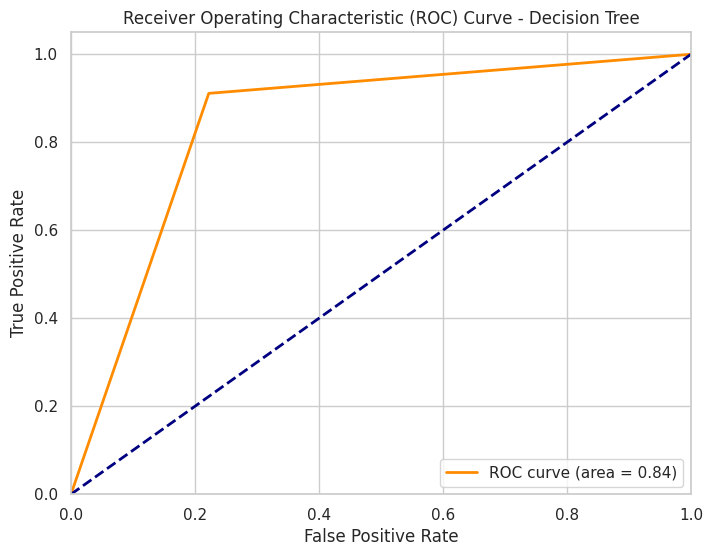

In [ ]:
print("Training Decision Tree model...")

dt_pipeline = Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=42))])

dt_pipeline.fit(X_train_80, y_train_80)

y_pred_dt = dt_pipeline.predict(X_test_20)

print("\nDecision Tree Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_dt))

n_classes = len(np.unique(y_train_80))

if n_classes > 2:
    print("\nClassification Report (Decision Tree):\n", classification_report(y_test_20, y_pred_dt))
    print("\nConfusion Matrix (Decision Tree):\n", confusion_matrix(y_test_20, y_pred_dt))
else:
    print("\nClassification Report (Decision Tree):\n", classification_report(y_test_20, y_pred_dt, zero_division=0))
    print("\nConfusion Matrix (Decision Tree):\n", confusion_matrix(y_test_20, y_pred_dt))

if n_classes == 2:
    try:
        y_prob_dt = dt_pipeline.predict_proba(X_test_20)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test_20, y_prob_dt)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("\nDecision Tree classifier does not support predict_proba for ROC curve plotting.")


**Decision Tree Hyperparameter Justification:**

*   `criterion` (Split quality measure): Determines how the quality of a split is measured ('gini', 'entropy').
*   `max_depth` (Maximum tree depth): Limits the depth of the tree to prevent overfitting.
*   `min_samples_split` (Minimum samples to split): Sets the minimum number of samples required to split a node.
*   `min_samples_leaf` (Minimum samples per leaf): Specifies the minimum number of samples required in a leaf node.

Performing GridSearchCV (80/20 split)...
Best Parameters (80/20 split): {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}

GridSearchCV Test Accuracy (80/20 split): 0.8722222222222222

Performing GridSearchCV (70/30 split)...
Best Parameters (70/30 split): {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}

GridSearchCV Test Accuracy (70/30 split): 0.8333333333333334

Performing GridSearchCV (60/40 split)...
Best Parameters (60/40 split): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}

GridSearchCV Test Accuracy (60/40 split): 0.8222222222222222

--- GridSearchCV Classification Reports and Confusion Matrices ---

GridSearchCV Classification Report (80/20 split Decision Tree):
               precision    recall  f1-score   support

       Besni       0.92      0.81      0.86        90
     Kecimen       0.83      0.93      0.88        90

    accuracy                          

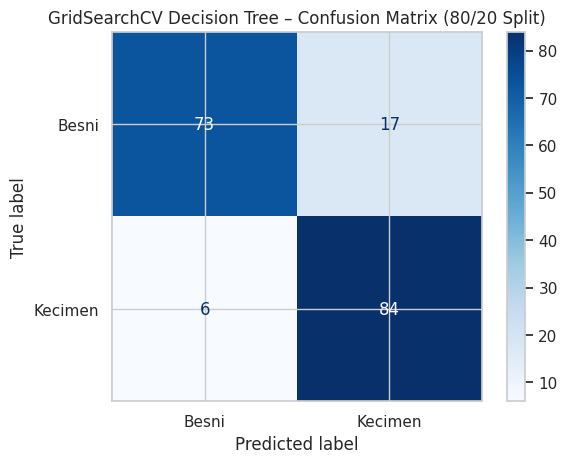


GridSearchCV Classification Report (70/30 split Decision Tree):
               precision    recall  f1-score   support

       Besni       0.86      0.80      0.83       135
     Kecimen       0.81      0.87      0.84       135

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270


GridSearchCV Confusion Matrix (70/30 split Decision Tree):


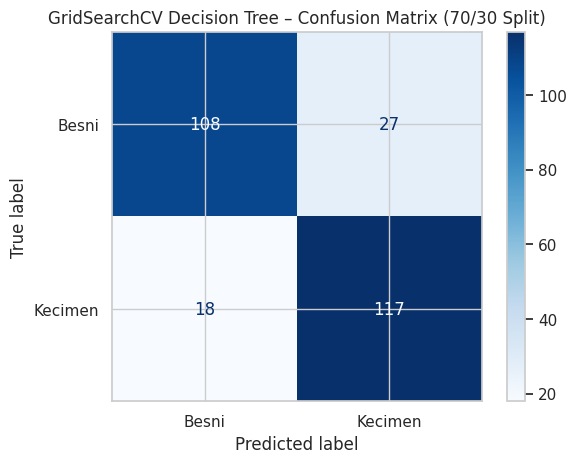


GridSearchCV Classification Report (60/40 split Decision Tree):
               precision    recall  f1-score   support

       Besni       0.85      0.78      0.81       180
     Kecimen       0.80      0.87      0.83       180

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.82      0.82      0.82       360


GridSearchCV Confusion Matrix (60/40 split Decision Tree):


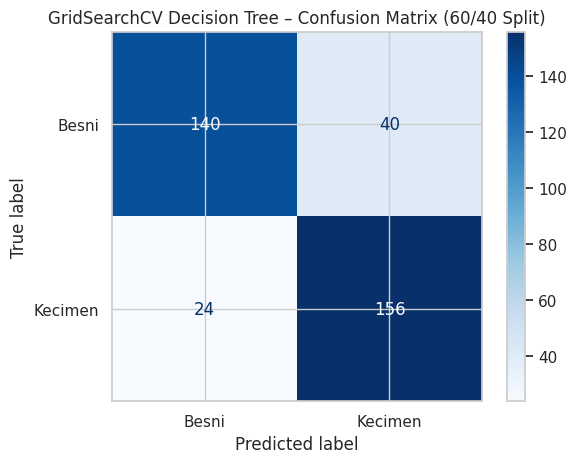


--- GridSearchCV ROC Curves ---


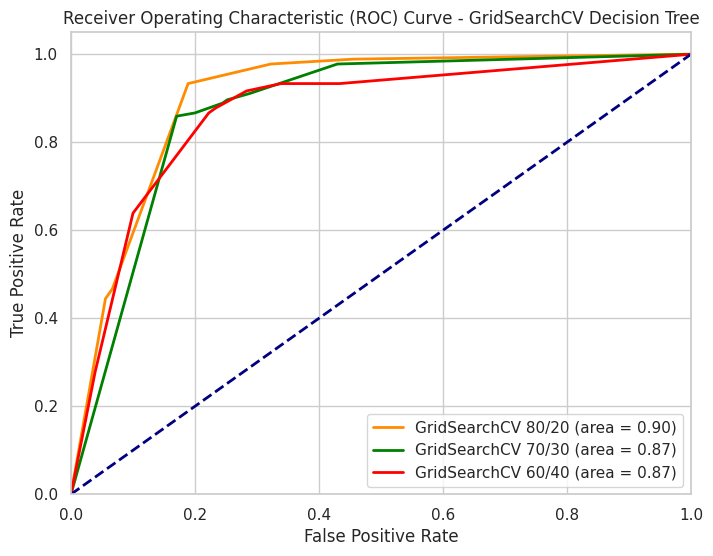

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing GridSearchCV (80/20 split)...")
grid_search_80 = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_80.fit(X_train_80, y_train_80)
best_dt_80 = grid_search_80.best_estimator_
print("Best Parameters (80/20 split):", grid_search_80.best_params_)
y_pred_dt_grid_80 = grid_search_80.predict(X_test_20)
print("\nGridSearchCV Test Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_dt_grid_80))

print("\nPerforming GridSearchCV (70/30 split)...")
grid_search_70 = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_70.fit(X_train_70, y_train_70)
best_dt_70 = grid_search_70.best_estimator_
print("Best Parameters (70/30 split):", grid_search_70.best_params_)
y_pred_dt_grid_70 = grid_search_70.predict(X_test_30)
print("\nGridSearchCV Test Accuracy (70/30 split):", accuracy_score(y_test_30, y_pred_dt_grid_70))

print("\nPerforming GridSearchCV (60/40 split)...")
grid_search_60 = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_60.fit(X_train_60, y_train_60)
best_dt_60 = grid_search_60.best_estimator_
print("Best Parameters (60/40 split):", grid_search_60.best_params_)
y_pred_dt_grid_60 = grid_search_60.predict(X_test_40)
print("\nGridSearchCV Test Accuracy (60/40 split):", accuracy_score(y_test_40, y_pred_dt_grid_60))


n_classes = len(np.unique(y_train_80))
class_names = label_encoder.classes_

print("\n--- GridSearchCV Classification Reports and Confusion Matrices ---")

print("\nGridSearchCV Classification Report (80/20 split Decision Tree):\n", classification_report(y_test_20, y_pred_dt_grid_80, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (80/20 split Decision Tree):")
cm_grid_dt_80 = confusion_matrix(y_test_20, y_pred_dt_grid_80)
ConfusionMatrixDisplay(cm_grid_dt_80, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV Decision Tree – Confusion Matrix (80/20 Split)')
plt.show()

print("\nGridSearchCV Classification Report (70/30 split Decision Tree):\n", classification_report(y_test_30, y_pred_dt_grid_70, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (70/30 split Decision Tree):")
cm_grid_dt_70 = confusion_matrix(y_test_30, y_pred_dt_grid_70)
ConfusionMatrixDisplay(cm_grid_dt_70, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV Decision Tree – Confusion Matrix (70/30 Split)')
plt.show()

print("\nGridSearchCV Classification Report (60/40 split Decision Tree):\n", classification_report(y_test_40, y_pred_dt_grid_60, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (60/40 split Decision Tree):")
cm_grid_dt_60 = confusion_matrix(y_test_40, y_pred_dt_grid_60)
ConfusionMatrixDisplay(cm_grid_dt_60, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV Decision Tree – Confusion Matrix (60/40 Split)')
plt.show()


if n_classes == 2:
    try:
        print("\n--- GridSearchCV ROC Curves ---")
        plt.figure(figsize=(8, 6))

        y_prob_dt_grid_80 = grid_search_80.predict_proba(X_test_20)[:, 1]
        fpr_grid_dt_80, tpr_grid_dt_80, _ = roc_curve(y_test_20, y_prob_dt_grid_80)
        roc_auc_grid_dt_80 = auc(fpr_grid_dt_80, tpr_grid_dt_80)
        plt.plot(fpr_grid_dt_80, tpr_grid_dt_80, color='darkorange', lw=2, label='GridSearchCV 80/20 (area = %0.2f)' % roc_auc_grid_dt_80)

        y_prob_dt_grid_70 = grid_search_70.predict_proba(X_test_30)[:, 1]
        fpr_grid_dt_70, tpr_grid_dt_70, _ = roc_curve(y_test_30, y_prob_dt_grid_70)
        roc_auc_grid_dt_70 = auc(fpr_grid_dt_70, tpr_grid_dt_70)
        plt.plot(fpr_grid_dt_70, tpr_grid_dt_70, color='green', lw=2, label='GridSearchCV 70/30 (area = %0.2f)' % roc_auc_grid_dt_70)

        y_prob_dt_grid_60 = grid_search_60.predict_proba(X_test_40)[:, 1]
        fpr_grid_dt_60, tpr_grid_dt_60, _ = roc_curve(y_test_40, y_prob_dt_grid_60)
        roc_auc_grid_dt_60 = auc(fpr_grid_dt_60, tpr_grid_dt_60)
        plt.plot(fpr_grid_dt_60, tpr_grid_dt_60, color='red', lw=2, label='GridSearchCV 60/40 (area = %0.2f)' % roc_auc_grid_dt_60)

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve - GridSearchCV Decision Tree')
        plt.legend(loc="lower right")
        plt.show()

    except AttributeError:
        print("\nDecision Tree classifier does not support predict_proba for ROC curve plotting with this configuration.")


# Nagendra Singh - KNN

Training KNN model...

KNN Accuracy (80/20 split): 0.8611111111111112

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.93      0.78      0.85        90
           1       0.81      0.94      0.87        90

    accuracy                           0.86       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.86      0.86       180


Confusion Matrix (KNN):
 [[70 20]
 [ 5 85]]


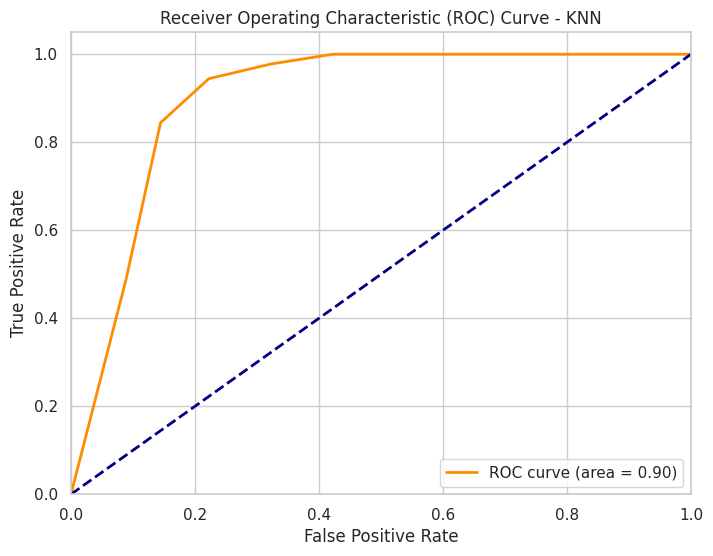

In [ ]:
print("Training KNN model...")

knn_pipeline = Pipeline(steps=[('classifier', KNeighborsClassifier())])

knn_pipeline.fit(X_train_80, y_train_80)

y_pred_knn = knn_pipeline.predict(X_test_20)

print("\nKNN Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_knn))

n_classes = len(np.unique(y_train_80))

if n_classes > 2:
    print("\nClassification Report (KNN):\n", classification_report(y_test_20, y_pred_knn))
    print("\nConfusion Matrix (KNN):\n", confusion_matrix(y_test_20, y_pred_knn))
else:
    print("\nClassification Report (KNN):\n", classification_report(y_test_20, y_pred_knn, zero_division=0))
    print("\nConfusion Matrix (KNN):\n", confusion_matrix(y_test_20, y_pred_knn))

if n_classes == 2:
    y_prob_knn = knn_pipeline.predict_proba(X_test_20)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_20, y_prob_knn)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
    plt.legend(loc="lower right")
    plt.show()


**KNN Hyperparameter Justification:**

*   `n_neighbors` (Number of neighbors): Defines the number of nearest data points considered for classification.
*   `weights` (Weighting of neighbors): Determines how the contribution of neighbors is weighted ('uniform', 'distance').
*   `metric` (Distance metric): Specifies how the distance between data points is calculated ('euclidean', 'manhattan', 'minkowski').

Performing GridSearchCV on KNN (80/20 split)...
Best Parameters (80/20 split): {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Test Accuracy (80/20 split): 0.8777777777777778

Performing GridSearchCV on KNN (70/30 split)...
Best Parameters (70/30 split): {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Test Accuracy (70/30 split): 0.825925925925926

Performing GridSearchCV on KNN (60/40 split)...
Best Parameters (60/40 split): {'knn__metric': 'manhattan', 'knn__n_neighbors': 12, 'knn__weights': 'uniform'}
Test Accuracy (60/40 split): 0.8388888888888889

--- GridSearchCV Classification Reports and Confusion Matrices ---

GridSearchCV Classification Report (80/20 split KNN):
               precision    recall  f1-score   support

       Besni       0.95      0.80      0.87        90
     Kecimen       0.83      0.96      0.89        90

    accuracy                           0.88       180
   macro avg       0.89      0.88   

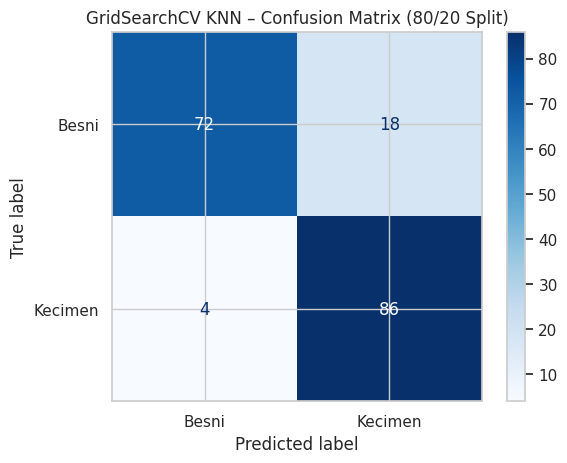


GridSearchCV Classification Report (70/30 split KNN):
               precision    recall  f1-score   support

       Besni       0.87      0.76      0.81       135
     Kecimen       0.79      0.89      0.84       135

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270


GridSearchCV Confusion Matrix (70/30 split KNN):


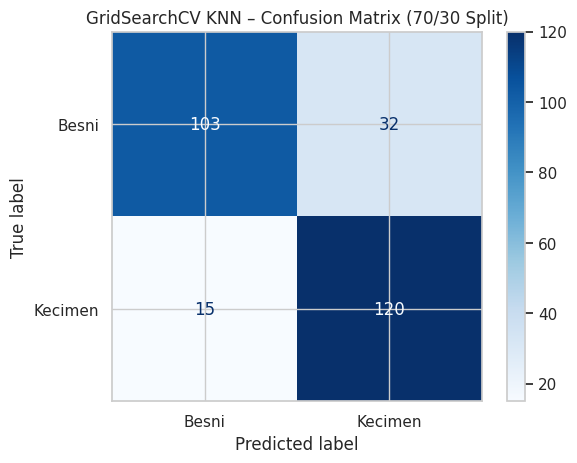


GridSearchCV Classification Report (60/40 split KNN):
               precision    recall  f1-score   support

       Besni       0.89      0.77      0.83       180
     Kecimen       0.80      0.91      0.85       180

    accuracy                           0.84       360
   macro avg       0.85      0.84      0.84       360
weighted avg       0.85      0.84      0.84       360


GridSearchCV Confusion Matrix (60/40 split KNN):


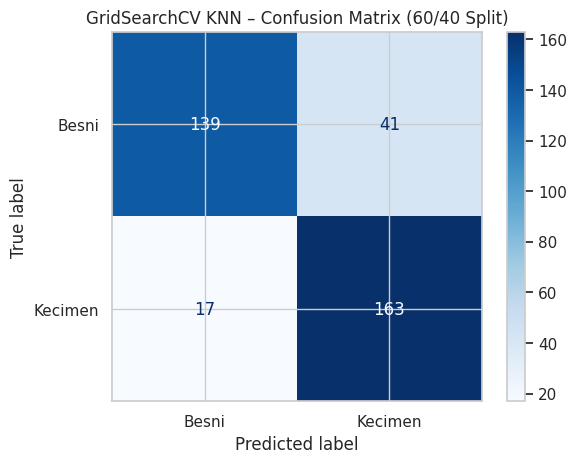


--- GridSearchCV ROC Curves ---


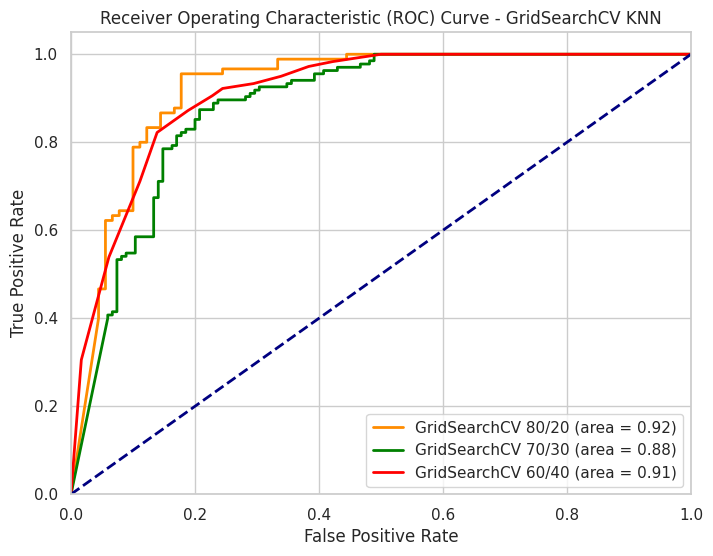

In [ ]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_split, y_split, test_size=0.2, random_state=42, stratify=y_split)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_split, y_split, test_size=0.3, random_state=42, stratify=y_split)
X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X_split, y_split, test_size=0.4, random_state=42, stratify=y_split)

y_test_20_encoded = y_test_20
y_test_30_encoded = y_test_30
y_test_40_encoded = y_test_40


pipe = Pipeline([('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': range(3, 16),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Performing GridSearchCV on KNN (80/20 split)...")
grid_80 = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_80.fit(X_train_80, y_train_80)
print('Best Parameters (80/20 split):', grid_80.best_params_)
best_knn_80 = grid_80.best_estimator_
y_pred_80 = best_knn_80.predict(X_test_20)
y_prob_80 = best_knn_80.predict_proba(X_test_20)[:, 1] if len(np.unique(y_split)) == 2 else None
print("Test Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_80))


print("\nPerforming GridSearchCV on KNN (70/30 split)...")
grid_70 = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_70.fit(X_train_70, y_train_70)
print('Best Parameters (70/30 split):', grid_70.best_params_)
best_knn_70 = grid_70.best_estimator_
y_pred_70 = best_knn_70.predict(X_test_30)
y_prob_70 = best_knn_70.predict_proba(X_test_30)[:, 1] if len(np.unique(y_split)) == 2 else None
print("Test Accuracy (70/30 split):", accuracy_score(y_test_30, y_pred_70))

print("\nPerforming GridSearchCV on KNN (60/40 split)...")
grid_60 = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_60.fit(X_train_60, y_train_60)
print('Best Parameters (60/40 split):', grid_60.best_params_)
best_knn_60 = grid_60.best_estimator_
y_pred_60 = best_knn_60.predict(X_test_40)
y_prob_60 = best_knn_60.predict_proba(X_test_40)[:, 1] if len(np.unique(y_split)) == 2 else None
print("Test Accuracy (60/40 split):", accuracy_score(y_test_40, y_pred_60))


class_names = label_encoder.classes_

print("\n--- GridSearchCV Classification Reports and Confusion Matrices ---")

print("\nGridSearchCV Classification Report (80/20 split KNN):\n", classification_report(y_test_20, y_pred_80, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (80/20 split KNN):")
cm_grid_80 = confusion_matrix(y_test_20, y_pred_80)
ConfusionMatrixDisplay(cm_grid_80, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV KNN – Confusion Matrix (80/20 Split)')
plt.show()

print("\nGridSearchCV Classification Report (70/30 split KNN):\n", classification_report(y_test_30, y_pred_70, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (70/30 split KNN):")
cm_grid_70 = confusion_matrix(y_test_30, y_pred_70)
ConfusionMatrixDisplay(cm_grid_70, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV KNN – Confusion Matrix (70/30 Split)')
plt.show()

print("\nGridSearchCV Classification Report (60/40 split KNN):\n", classification_report(y_test_40, y_pred_60, target_names=class_names))
print("\nGridSearchCV Confusion Matrix (60/40 split KNN):")
cm_grid_60 = confusion_matrix(y_test_40, y_pred_60)
ConfusionMatrixDisplay(cm_grid_60, display_labels=class_names).plot(cmap='Blues')
plt.title('GridSearchCV KNN – Confusion Matrix (60/40 Split)')
plt.show()


if len(np.unique(y_split)) == 2:
    print("\n--- GridSearchCV ROC Curves ---")
    plt.figure(figsize=(8, 6))

    fpr_grid_80, tpr_grid_80, _ = roc_curve(y_test_20_encoded, y_prob_80)
    roc_auc_grid_80 = auc(fpr_grid_80, tpr_grid_80)
    plt.plot(fpr_grid_80, tpr_grid_80, color='darkorange', lw=2, label='GridSearchCV 80/20 (area = %0.2f)' % roc_auc_grid_80)

    fpr_grid_70, tpr_grid_70, _ = roc_curve(y_test_30_encoded, y_prob_70)
    roc_auc_grid_70 = auc(fpr_grid_70, tpr_grid_70)
    plt.plot(fpr_grid_70, tpr_grid_70, color='green', lw=2, label='GridSearchCV 70/30 (area = %0.2f)' % roc_auc_grid_70)

    fpr_grid_60, tpr_grid_60, _ = roc_curve(y_test_40_encoded, y_prob_60)
    roc_auc_grid_60 = auc(fpr_grid_60, tpr_grid_60)
    plt.plot(fpr_grid_60, tpr_grid_60, color='red', lw=2, label='GridSearchCV 60/40 (area = %0.2f)' % roc_auc_grid_60)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - GridSearchCV KNN')
    plt.legend(loc="lower right")
    plt.show()


# Jaya Prakash - Naive Bayes

Training Naive Bayes model...

Naive Bayes Accuracy (80/20 split): 0.8333333333333334

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

           0       0.94      0.71      0.81        90
           1       0.77      0.96      0.85        90

    accuracy                           0.83       180
   macro avg       0.85      0.83      0.83       180
weighted avg       0.85      0.83      0.83       180


Confusion Matrix (Naive Bayes):
 [[64 26]
 [ 4 86]]


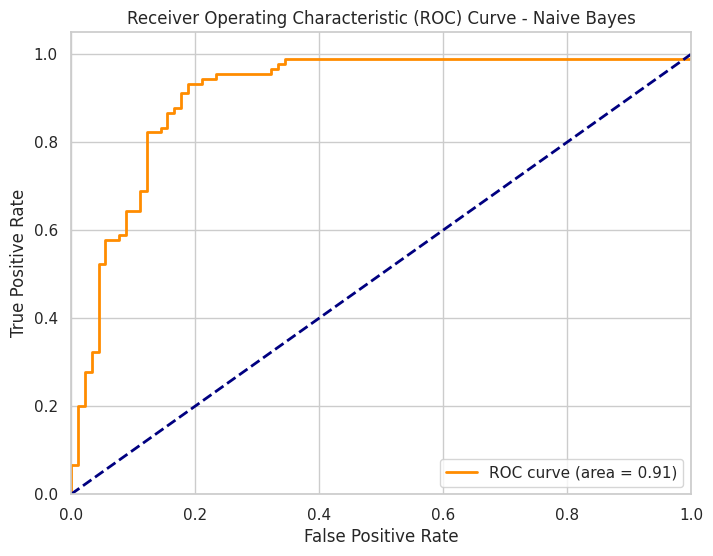

In [ ]:
print("Training Naive Bayes model...")

nb_pipeline = Pipeline(steps=[('classifier', GaussianNB())])

nb_pipeline.fit(X_train_80, y_train_80)

y_pred_nb = nb_pipeline.predict(X_test_20)

print("\nNaive Bayes Accuracy (80/20 split):", accuracy_score(y_test_20, y_pred_nb))

n_classes = len(np.unique(y_train_80))

if n_classes > 2:
    print("\nClassification Report (Naive Bayes):\n", classification_report(y_test_20, y_pred_nb))
    print("\nConfusion Matrix (Naive Bayes):\n", confusion_matrix(y_test_20, y_pred_nb))
else:
    print("\nClassification Report (Naive Bayes):\n", classification_report(y_test_20, y_pred_nb, zero_division=0))
    print("\nConfusion Matrix (Naive Bayes):\n", confusion_matrix(y_test_20, y_pred_nb))

if n_classes == 2:
    y_prob_nb = nb_pipeline.predict_proba(X_test_20)[:, 1]
    y_test_20_encoded_for_roc = y_test_20
    fpr, tpr, thresholds = roc_curve(y_test_20_encoded_for_roc, y_prob_nb)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Naive Bayes')
    plt.legend(loc="lower right")
    plt.show()


**Gaussian Naive Bayes Hyperparameter Justification:**

*   `var_smoothing` (Additive smoothing): Adds a small value to variances to improve numerical stability and handle zero frequencies.


--- Starting GridSearchCV for GaussianNB (80/20 split) ---

--- GridSearchCV (80/20 split GaussianNB) Complete ---
Best parameters found: {}
Best cross-validation accuracy: 0.8361

GridSearchCV Test Accuracy: 0.8333

--- Starting GridSearchCV for GaussianNB (70/30 split) ---

--- GridSearchCV (70/30 split GaussianNB) Complete ---
Best parameters found: {}
Best cross-validation accuracy: 0.8540

GridSearchCV Test Accuracy: 0.7963

--- Starting GridSearchCV for GaussianNB (60/40 split) ---

--- GridSearchCV (60/40 split GaussianNB) Complete ---
Best parameters found: {}
Best cross-validation accuracy: 0.8537

GridSearchCV Test Accuracy: 0.8139

--- Starting RandomizedSearchCV for GaussianNB (80/20 split) ---

--- RandomizedSearchCV (80/20 split GaussianNB) Complete ---
Best parameters found: {'var_smoothing': np.float64(0.004518560951024112)}
Best cross-validation accuracy: 0.8375

RandomizedSearchCV Test Accuracy: 0.8333

--- Starting RandomizedSearchCV for GaussianNB (70/30 split) ---

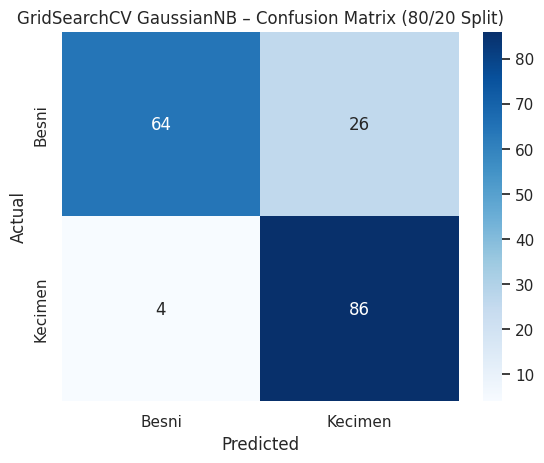


GridSearchCV Best Estimator Classification Report (70/30 split):
              precision    recall  f1-score   support

       Besni       0.89      0.67      0.77       135
     Kecimen       0.74      0.92      0.82       135

    accuracy                           0.80       270
   macro avg       0.82      0.80      0.79       270
weighted avg       0.82      0.80      0.79       270


GridSearchCV Best Estimator Confusion Matrix (70/30 split):


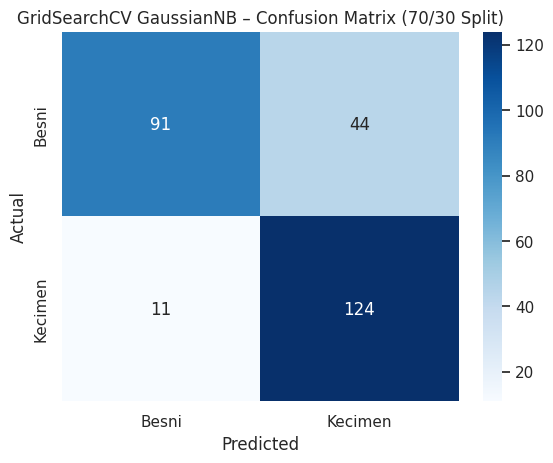


GridSearchCV Best Estimator Classification Report (60/40 split):
              precision    recall  f1-score   support

       Besni       0.92      0.68      0.79       180
     Kecimen       0.75      0.94      0.84       180

    accuracy                           0.81       360
   macro avg       0.84      0.81      0.81       360
weighted avg       0.84      0.81      0.81       360


GridSearchCV Best Estimator Confusion Matrix (60/40 split):


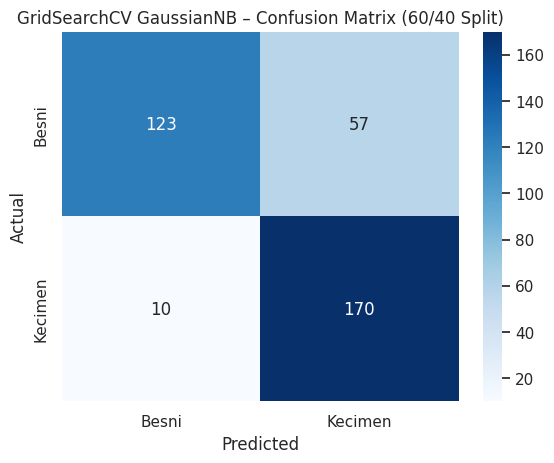


RandomizedSearchCV Best Estimator Classification Report (80/20 split):
              precision    recall  f1-score   support

       Besni       0.94      0.71      0.81        90
     Kecimen       0.77      0.96      0.85        90

    accuracy                           0.83       180
   macro avg       0.85      0.83      0.83       180
weighted avg       0.85      0.83      0.83       180


RandomizedSearchCV Best Estimator Confusion Matrix (80/20 split):


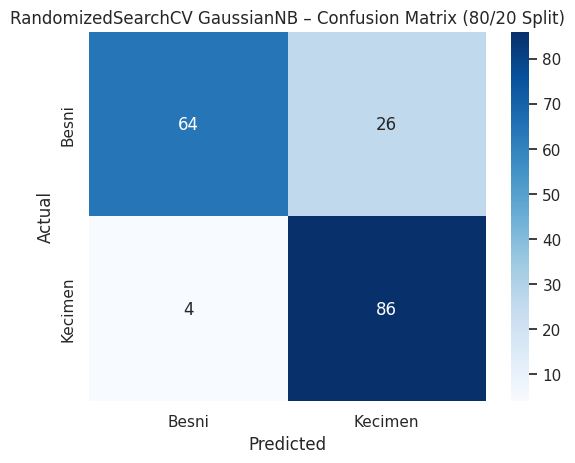


RandomizedSearchCV Best Estimator Classification Report (70/30 split):
              precision    recall  f1-score   support

       Besni       0.90      0.67      0.77       135
     Kecimen       0.74      0.93      0.82       135

    accuracy                           0.80       270
   macro avg       0.82      0.80      0.80       270
weighted avg       0.82      0.80      0.80       270


RandomizedSearchCV Best Estimator Confusion Matrix (70/30 split):


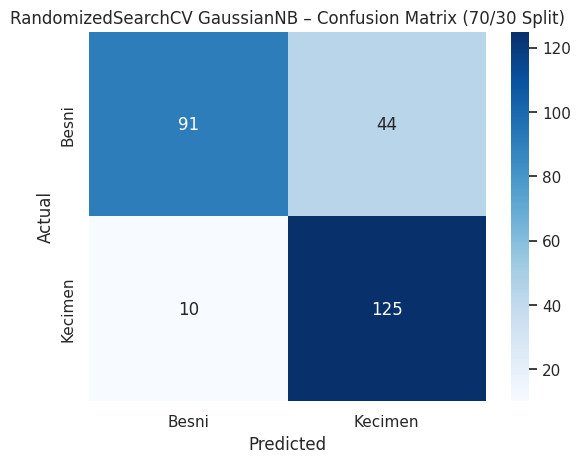


RandomizedSearchCV Best Estimator Classification Report (60/40 split):
              precision    recall  f1-score   support

       Besni       0.92      0.68      0.79       180
     Kecimen       0.75      0.94      0.84       180

    accuracy                           0.81       360
   macro avg       0.84      0.81      0.81       360
weighted avg       0.84      0.81      0.81       360


RandomizedSearchCV Best Estimator Confusion Matrix (60/40 split):


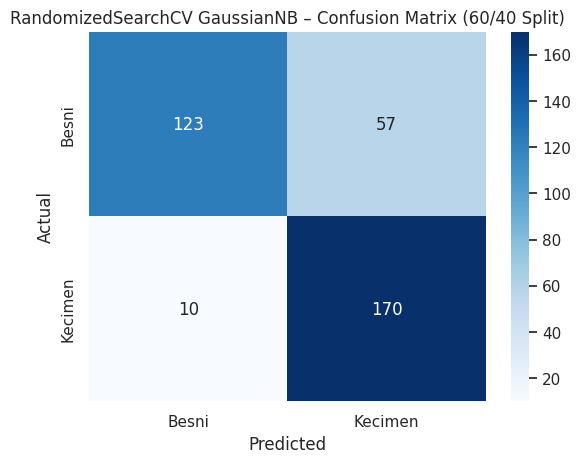


GridSearchCV Best Estimator ROC Curve:


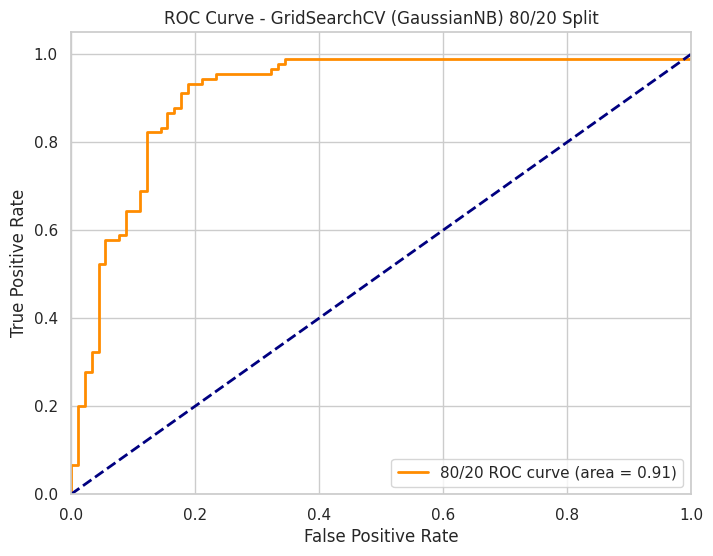

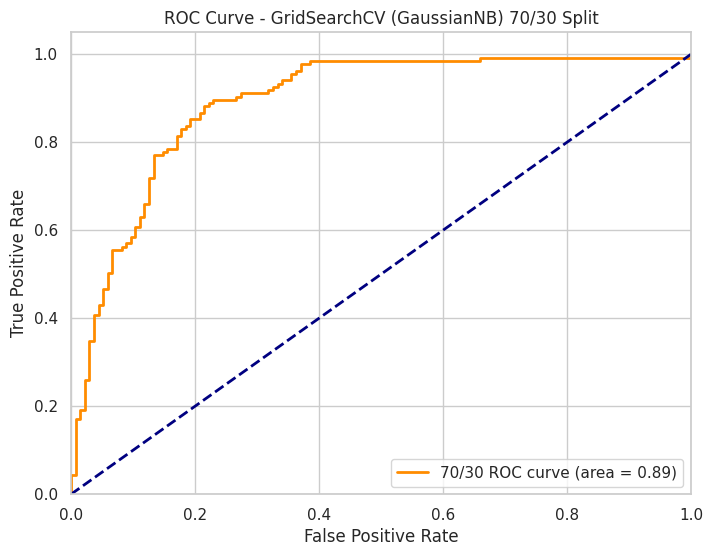

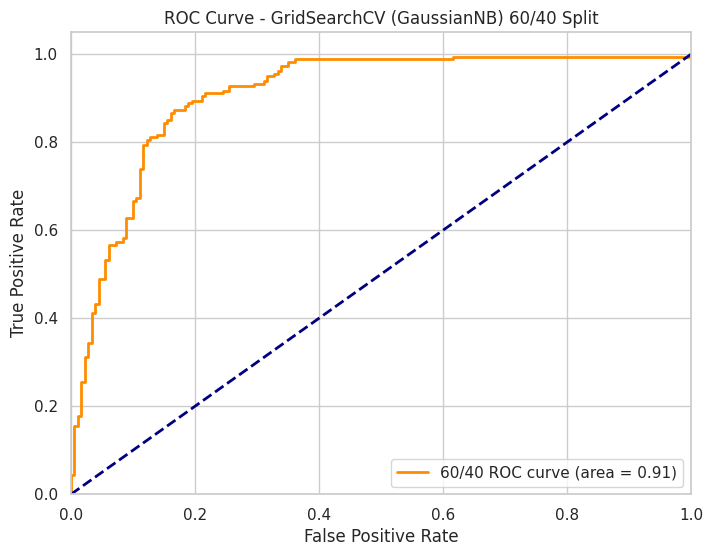


RandomizedSearchCV Best Estimator ROC Curve:


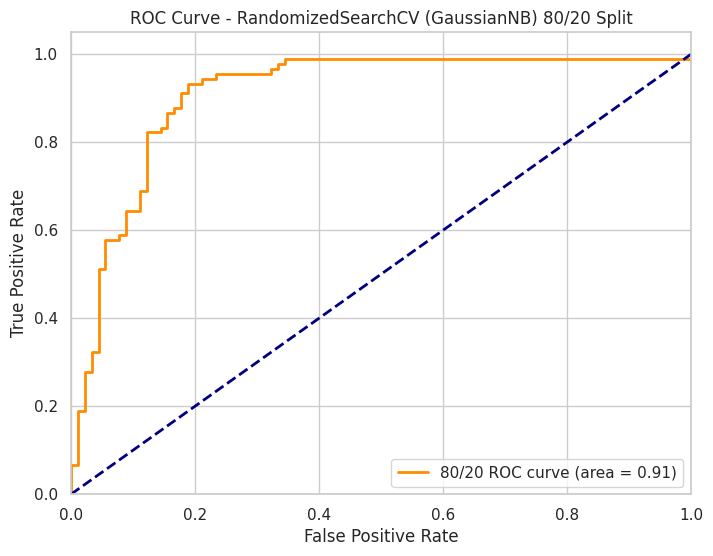

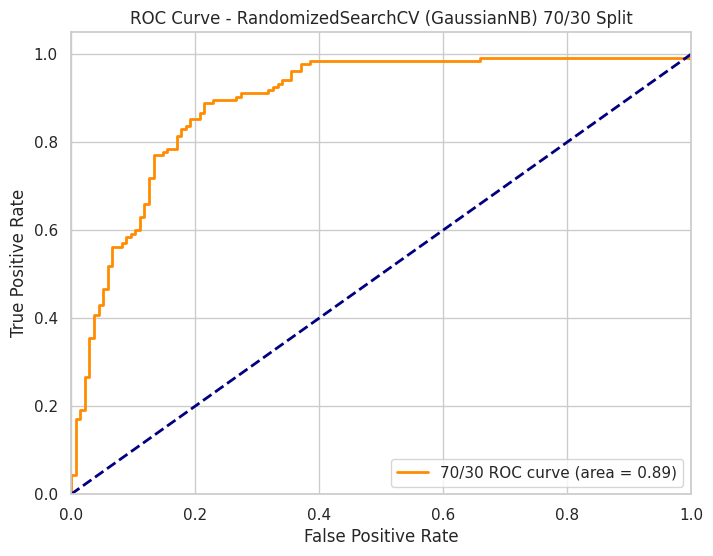

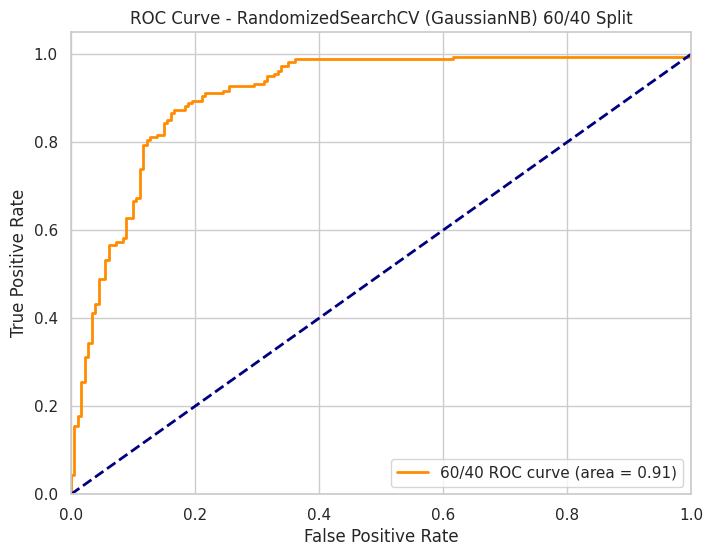

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import loguniform

nb = GaussianNB()

print("\n--- Starting GridSearchCV for GaussianNB (80/20 split) ---")
param_grid_nb = {}
grid_search_nb_80 = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb_80.fit(X_train_80, y_train_80)
print("\n--- GridSearchCV (80/20 split GaussianNB) Complete ---")
print(f"Best parameters found: {grid_search_nb_80.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_nb_80.best_score_:.4f}")
y_pred_grid_nb_80 = grid_search_nb_80.predict(X_test_20)
print(f"\nGridSearchCV Test Accuracy: {accuracy_score(y_test_20, y_pred_grid_nb_80):.4f}")

print("\n--- Starting GridSearchCV for GaussianNB (70/30 split) ---")
grid_search_nb_70 = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb_70.fit(X_train_70, y_train_70)
print("\n--- GridSearchCV (70/30 split GaussianNB) Complete ---")
print(f"Best parameters found: {grid_search_nb_70.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_nb_70.best_score_:.4f}")
y_pred_grid_nb_70 = grid_search_nb_70.predict(X_test_30)
print(f"\nGridSearchCV Test Accuracy: {accuracy_score(y_test_30, y_pred_grid_nb_70):.4f}")

print("\n--- Starting GridSearchCV for GaussianNB (60/40 split) ---")
grid_search_nb_60 = GridSearchCV(estimator=nb, param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_nb_60.fit(X_train_60, y_train_60)
print("\n--- GridSearchCV (60/40 split GaussianNB) Complete ---")
print(f"Best parameters found: {grid_search_nb_60.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_nb_60.best_score_:.4f}")
y_pred_grid_nb_60 = grid_search_nb_60.predict(X_test_40)
print(f"\nGridSearchCV Test Accuracy: {accuracy_score(y_test_40, y_pred_grid_nb_60):.4f}")


print("\n--- Starting RandomizedSearchCV for GaussianNB (80/20 split) ---")
param_dist_nb = {
    'var_smoothing': loguniform(1e-9, 1e-2)
}
random_search_nb_80 = RandomizedSearchCV(
    estimator=nb,
    param_distributions=param_dist_nb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search_nb_80.fit(X_train_80, y_train_80)
print("\n--- RandomizedSearchCV (80/20 split GaussianNB) Complete ---")
print(f"Best parameters found: {random_search_nb_80.best_params_}")
print(f"Best cross-validation accuracy: {random_search_nb_80.best_score_:.4f}")
y_pred_random_nb_80 = random_search_nb_80.predict(X_test_20)
print(f"\nRandomizedSearchCV Test Accuracy: {accuracy_score(y_test_20, y_pred_random_nb_80):.4f}")

print("\n--- Starting RandomizedSearchCV for GaussianNB (70/30 split) ---")
random_search_nb_70 = RandomizedSearchCV(
    estimator=nb,
    param_distributions=param_dist_nb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search_nb_70.fit(X_train_70, y_train_70)
print("\n--- RandomizedSearchCV (70/30 split GaussianNB) Complete ---")
print(f"Best parameters found: {random_search_nb_70.best_params_}")
print(f"Best cross-validation accuracy: {random_search_nb_70.best_score_:.4f}")
y_pred_random_nb_70 = random_search_nb_70.predict(X_test_30)
print(f"\nRandomizedSearchCV Test Accuracy: {accuracy_score(y_test_30, y_pred_random_nb_70):.4f}")

print("\n--- Starting RandomizedSearchCV for GaussianNB (60/40 split) ---")
random_search_nb_60 = RandomizedSearchCV(
    estimator=nb,
    param_distributions=param_dist_nb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search_nb_60.fit(X_train_60, y_train_60)
print("\n--- RandomizedSearchCV (60/40 split GaussianNB) Complete ---")
print(f"Best parameters found: {random_search_nb_60.best_params_}")
print(f"Best cross-validation accuracy: {random_search_nb_60.best_score_:.4f}")
y_pred_random_nb_60 = random_search_nb_60.predict(X_test_40)
print(f"\nRandomizedSearchCV Test Accuracy: {accuracy_score(y_test_40, y_pred_random_nb_60):.4f}")


print("\nGridSearchCV Best Estimator Classification Report (80/20 split):")
print(classification_report(y_test_20, y_pred_grid_nb_80, target_names=label_encoder.classes_))
print("\nGridSearchCV Best Estimator Confusion Matrix (80/20 split):")
cm_grid_nb_80 = confusion_matrix(y_test_20, y_pred_grid_nb_80)
sns.heatmap(cm_grid_nb_80, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("GridSearchCV GaussianNB – Confusion Matrix (80/20 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()

print("\nGridSearchCV Best Estimator Classification Report (70/30 split):")
print(classification_report(y_test_30, y_pred_grid_nb_70, target_names=label_encoder.classes_))
print("\nGridSearchCV Best Estimator Confusion Matrix (70/30 split):")
cm_grid_nb_70 = confusion_matrix(y_test_30, y_pred_grid_nb_70)
sns.heatmap(cm_grid_nb_70, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("GridSearchCV GaussianNB – Confusion Matrix (70/30 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()

print("\nGridSearchCV Best Estimator Classification Report (60/40 split):")
print(classification_report(y_test_40, y_pred_grid_nb_60, target_names=label_encoder.classes_))
print("\nGridSearchCV Best Estimator Confusion Matrix (60/40 split):")
cm_grid_nb_60 = confusion_matrix(y_test_40, y_pred_grid_nb_60)
sns.heatmap(cm_grid_nb_60, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("GridSearchCV GaussianNB – Confusion Matrix (60/40 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()


print("\nRandomizedSearchCV Best Estimator Classification Report (80/20 split):")
print(classification_report(y_test_20, y_pred_random_nb_80, target_names=label_encoder.classes_))
print("\nRandomizedSearchCV Best Estimator Confusion Matrix (80/20 split):")
cm_random_nb_80 = confusion_matrix(y_test_20, y_pred_random_nb_80)
sns.heatmap(cm_random_nb_80, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("RandomizedSearchCV GaussianNB – Confusion Matrix (80/20 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()

print("\nRandomizedSearchCV Best Estimator Classification Report (70/30 split):")
print(classification_report(y_test_30, y_pred_random_nb_70, target_names=label_encoder.classes_))
print("\nRandomizedSearchCV Best Estimator Confusion Matrix (70/30 split):")
cm_random_nb_70 = confusion_matrix(y_test_30, y_pred_random_nb_70)
sns.heatmap(cm_random_nb_70, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("RandomizedSearchCV GaussianNB – Confusion Matrix (70/30 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()

print("\nRandomizedSearchCV Best Estimator Classification Report (60/40 split):")
print(classification_report(y_test_40, y_pred_random_nb_60, target_names=label_encoder.classes_))
print("\nRandomizedSearchCV Best Estimator Confusion Matrix (60/40 split):")
cm_random_nb_60 = confusion_matrix(y_test_40, y_pred_random_nb_60)
sns.heatmap(cm_random_nb_60, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("RandomizedSearchCV GaussianNB – Confusion Matrix (60/40 Split)")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.show()


if len(label_encoder.classes_) == 2:
    y_test_20_encoded = y_test_20
    y_test_30_encoded = y_test_30
    y_test_40_encoded = y_test_40

    print("\nGridSearchCV Best Estimator ROC Curve:")
    y_prob_grid_nb_80 = grid_search_nb_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_grid_nb_80, tpr_grid_nb_80, thresholds_grid_nb_80 = roc_curve(y_test_20_encoded, y_prob_grid_nb_80)
    roc_auc_grid_nb_80 = auc(fpr_grid_nb_80, tpr_grid_nb_80)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_grid_nb_80, tpr_grid_nb_80, color='darkorange', lw=2, label='80/20 ROC curve (area = %0.2f)' % roc_auc_grid_nb_80)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GridSearchCV (GaussianNB) 80/20 Split')
    plt.legend(loc="lower right")
    plt.show()

    y_prob_grid_nb_70 = grid_search_nb_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_grid_nb_70, tpr_grid_nb_70, thresholds_grid_nb_70 = roc_curve(y_test_30_encoded, y_prob_grid_nb_70)
    roc_auc_grid_nb_70 = auc(fpr_grid_nb_70, tpr_grid_nb_70)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_grid_nb_70, tpr_grid_nb_70, color='darkorange', lw=2, label='70/30 ROC curve (area = %0.2f)' % roc_auc_grid_nb_70)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GridSearchCV (GaussianNB) 70/30 Split')
    plt.legend(loc="lower right")
    plt.show()

    y_prob_grid_nb_60 = grid_search_nb_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_grid_nb_60, tpr_grid_nb_60, thresholds_grid_nb_60 = roc_curve(y_test_40_encoded, y_prob_grid_nb_60)
    roc_auc_grid_nb_60 = auc(fpr_grid_nb_60, tpr_grid_nb_60)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_grid_nb_60, tpr_grid_nb_60, color='darkorange', lw=2, label='60/40 ROC curve (area = %0.2f)' % roc_auc_grid_nb_60)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - GridSearchCV (GaussianNB) 60/40 Split')
    plt.legend(loc="lower right")
    plt.show()


    print("\nRandomizedSearchCV Best Estimator ROC Curve:")
    y_prob_random_nb_80 = random_search_nb_80.best_estimator_.predict_proba(X_test_20)[:, 1]
    fpr_random_nb_80, tpr_random_nb_80, thresholds_random_nb_80 = roc_curve(y_test_20_encoded, y_prob_random_nb_80)
    roc_auc_random_nb_80 = auc(fpr_random_nb_80, tpr_random_nb_80)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_random_nb_80, tpr_random_nb_80, color='darkorange', lw=2, label='80/20 ROC curve (area = %0.2f)' % roc_auc_random_nb_80)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomizedSearchCV (GaussianNB) 80/20 Split')
    plt.legend(loc="lower right")
    plt.show()

    y_prob_random_nb_70 = random_search_nb_70.best_estimator_.predict_proba(X_test_30)[:, 1]
    fpr_random_nb_70, tpr_random_nb_70, thresholds_random_nb_70 = roc_curve(y_test_30_encoded, y_prob_random_nb_70)
    roc_auc_random_70 = auc(fpr_random_nb_70, tpr_random_nb_70)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_random_nb_70, tpr_random_nb_70, color='darkorange', lw=2, label='70/30 ROC curve (area = %0.2f)' % roc_auc_random_70)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomizedSearchCV (GaussianNB) 70/30 Split')
    plt.legend(loc="lower right")
    plt.show()

    y_prob_random_nb_60 = random_search_nb_60.best_estimator_.predict_proba(X_test_40)[:, 1]
    fpr_random_nb_60, tpr_random_nb_60, thresholds_random_nb_60 = roc_curve(y_test_40_encoded, y_prob_random_nb_60)
    roc_auc_random_60 = auc(fpr_random_nb_60, tpr_random_nb_60)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_random_nb_60, tpr_random_nb_60, color='darkorange', lw=2, label='60/40 ROC curve (area = %0.2f)' % roc_auc_random_60)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - RandomizedSearchCV (GaussianNB) 60/40 Split')
    plt.legend(loc="lower right")
    plt.show()


# Performance Evaluations

#Logistic Regression and Decision Tree models

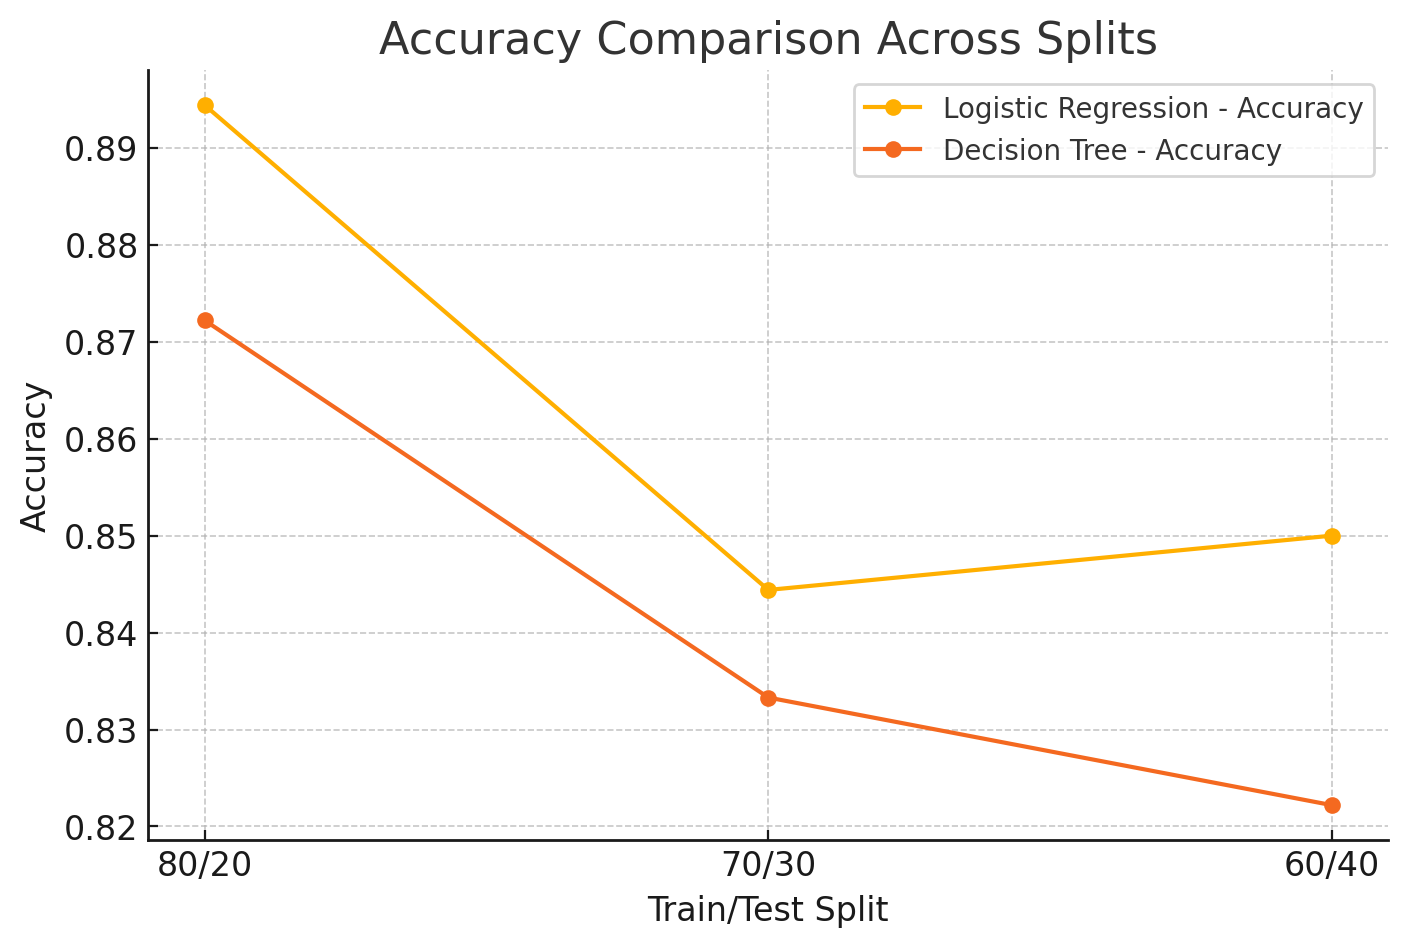

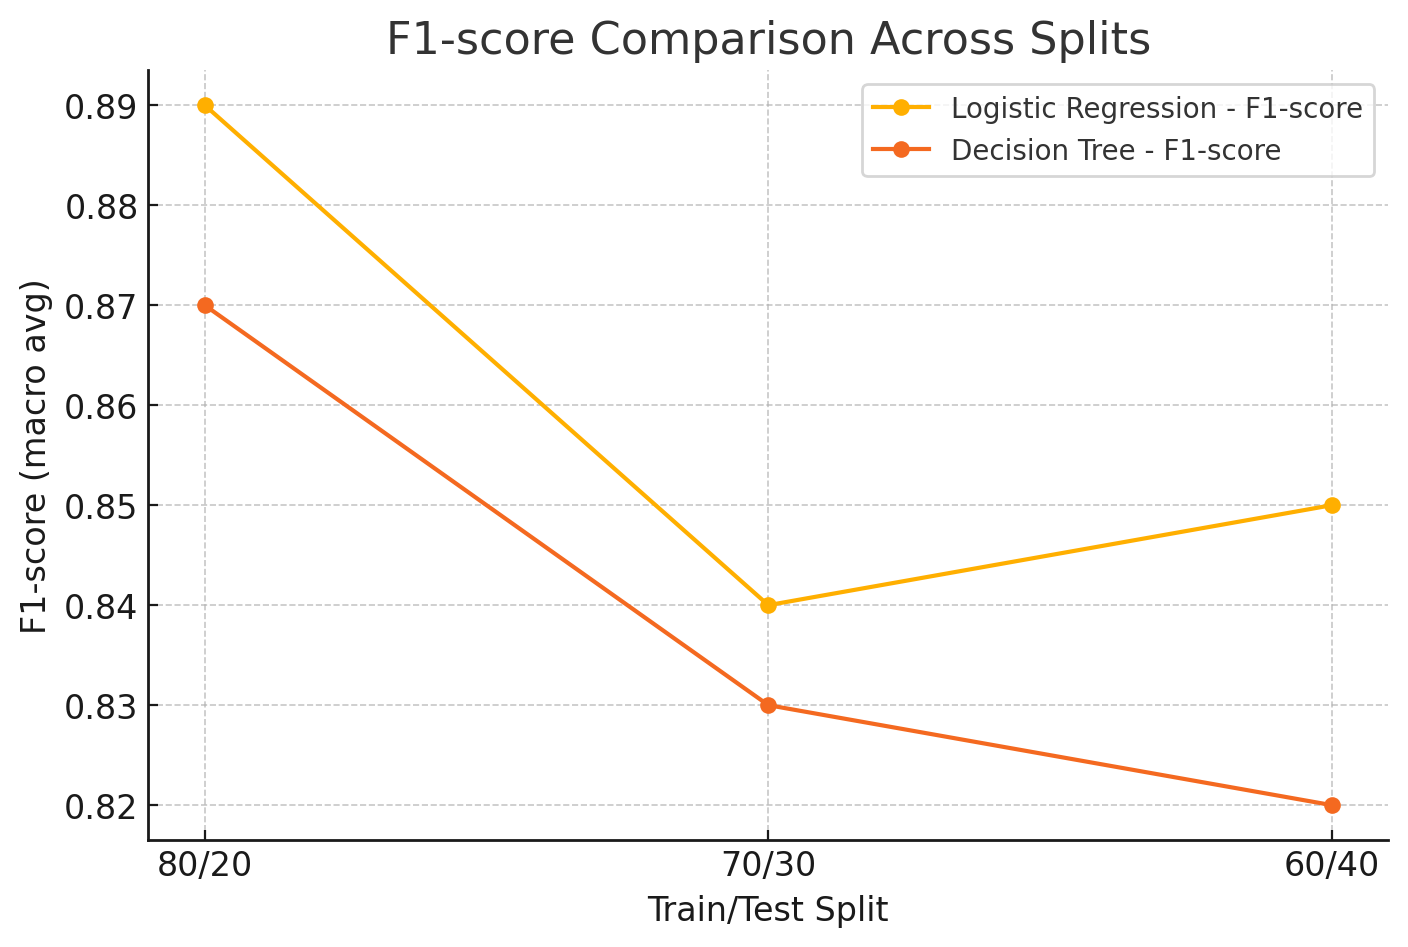

The visual comparison clearly shows that Logistic Regression consistently outperforms the Decision Tree model across all train-test splits, both in terms of accuracy and F1-score. While Decision Tree performance declines as the test size increases—indicating overfitting—Logistic Regression maintains stable and high metrics, reflecting strong generalization and balanced classification across classes.

#Overall for all models


### Model Performance Comparison

| Model (Tuning Method) | 80/20 Split Accuracy | 70/30 Split Accuracy | 60/40 Split Accuracy |
|-----------------------|----------------------|----------------------|----------------------|
| **SVM (GridSearchCV)**    | 0.8722               | 0.8370               | 0.8528               |
| **SVM (RandomizedSearchCV)** | 0.8778               | 0.8444               | 0.8583               |
| **Logistic Regression (GridSearchCV)** | **0.8944**           | 0.8444               | 0.8500               |
| **Logistic Regression (RandomizedSearchCV)** | **0.8944**           | 0.8444               | 0.8500               |
| **Decision Tree (GridSearchCV)** | 0.8722               | 0.8333               | 0.8222               |
| **KNN (GridSearchCV)**    | 0.8778               | 0.8259               | 0.8389               |
| **Naive Bayes (GridSearchCV)** | 0.8333               | 0.7963               | 0.8139               |
| **Naive Bayes (RandomizedSearchCV)** | 0.8333               | 0.8000               | 0.8139               |

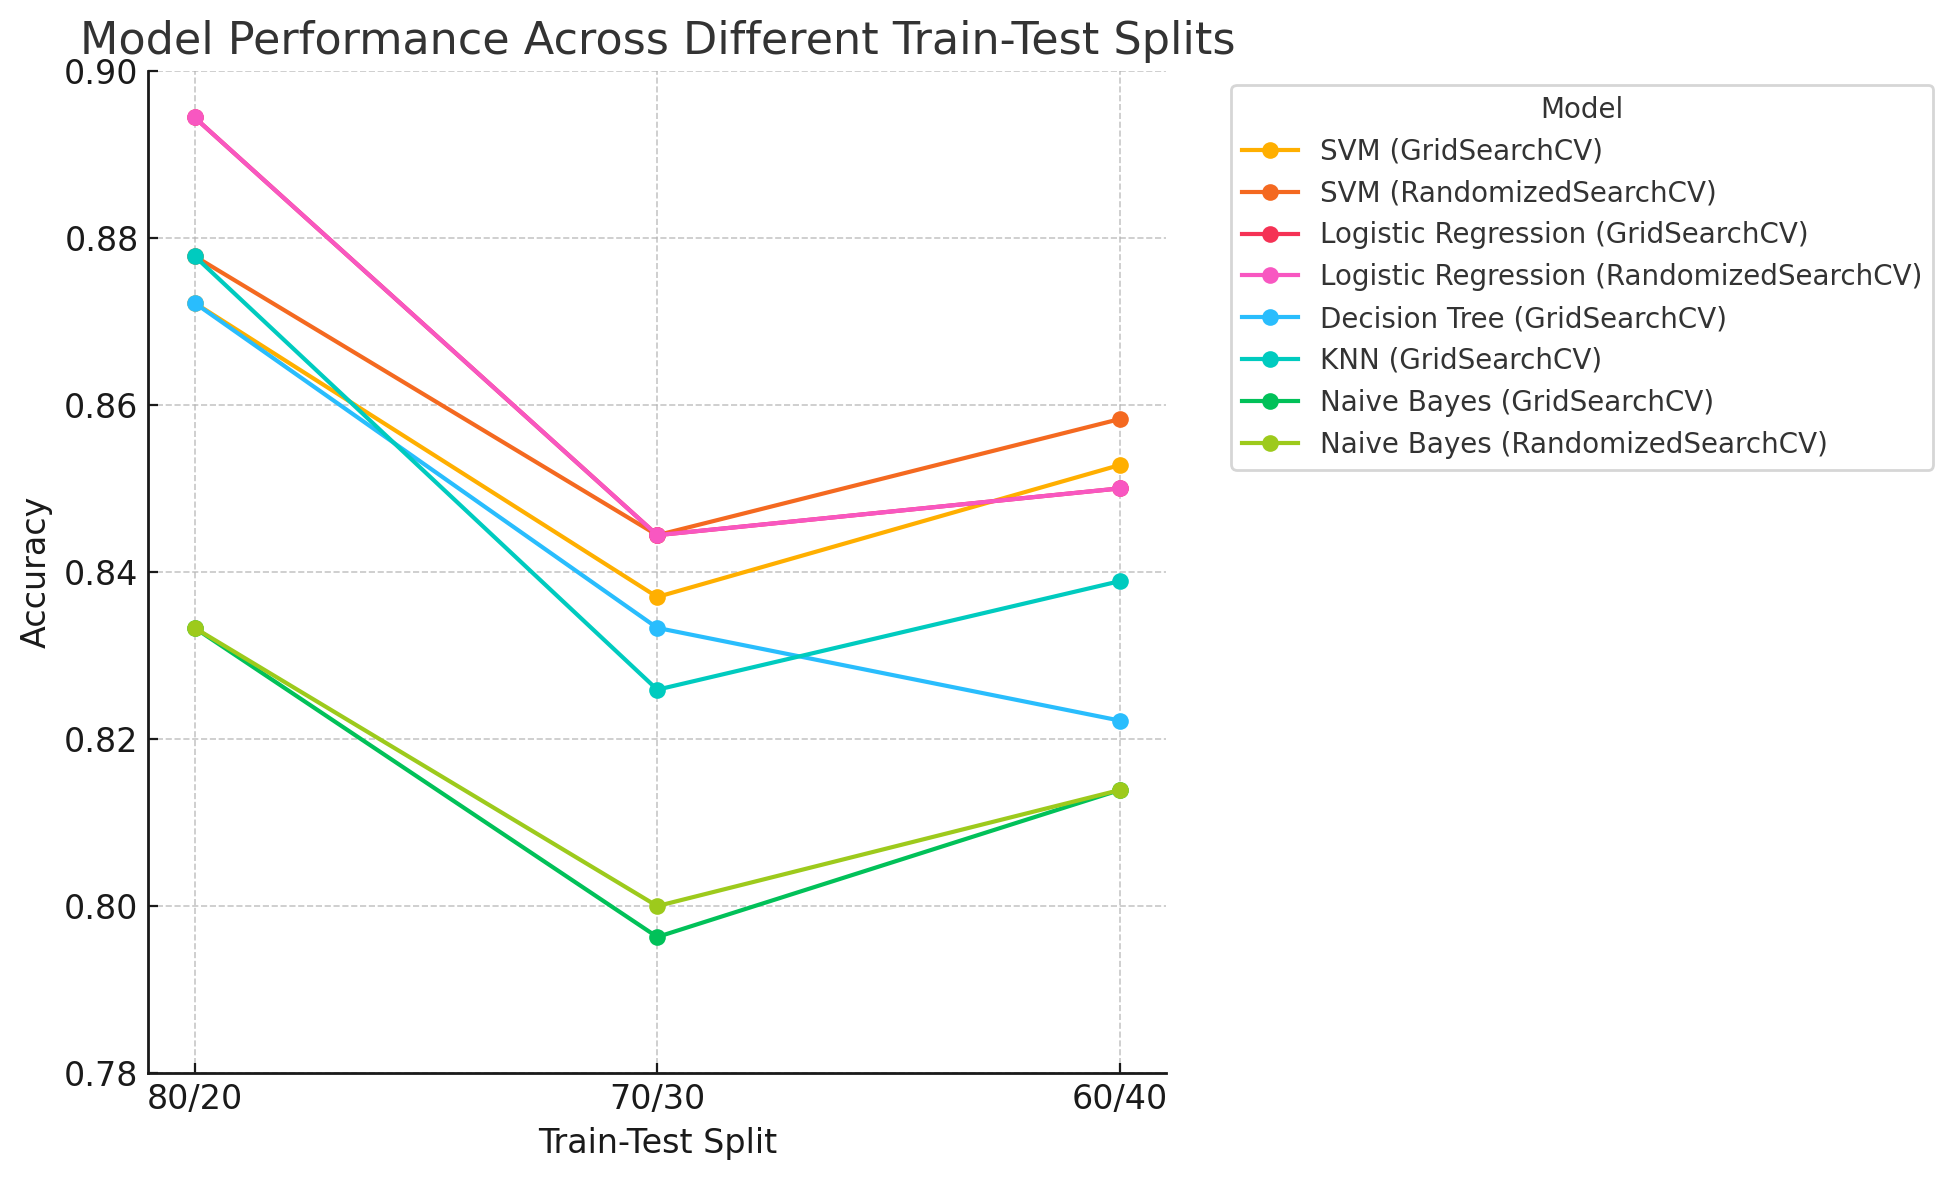

**Analysis:**

Based on the test accuracies across the different train-test splits and tuning methods:

* Logistic Regression achieved the highest overall accuracy (0.8944) in the 80/20 split, making it the top-performing model for this dataset.

* SVM (RandomizedSearchCV) performed almost as well and even outperformed Logistic Regression slightly in the 60/40 split (0.8583 vs 0.8500).

* For the 70/30 split, Logistic Regression and SVM (RandomizedSearchCV) showed identical accuracy (0.8444), indicating similar generalization ability.

* Other models (Decision Tree, KNN, Naive Bayes) consistently trail behind.


**Conclusion:**

Overall:

* Logistic Regression demonstrated the most stable and consistent performance across all splits and tuning methods.

* SVM remains a strong alternative, especially when more data is used for testing.

* Decision Tree, KNN, and Naive Bayes models consistently showed lower accuracy and less stability compared to Logistic Regression and SVM.

* Overall, Logistic Regression can be considered the best-performing and most reliable model for this dataset, with SVM (RandomizedSearchCV) as a close second.